In [61]:
import pandas as pd
import matplotlib.pyplot as plt  # To visualize
import seaborn as sns
import numpy as np
from tabulate import tabulate #To create pretty tables
import os, sys

In [2]:
directory = "/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment1_final_increasing/2020_09_22__08_18_48"
#directory = "/home/jeanpierre/libra2/libra2/experiments_logs/Experiment1/5_nodes/2020_09_18__14_07_08/"

In [3]:
# Load:"CPU_LOAD_DATAFRAME"
def get_cpu_dataframe(directory):
    cpu_dataframe = pd.read_csv(directory + "merged/jp_cpu_load.csv", names=["load", "timestamp"])
    return cpu_dataframe

# Load:"MEMPOOL_SIZE"
def get_mempool_size_dataframe(directory):
    mempool_size_dataframe = pd.read_csv(directory + "merged/jp_mempool_size.csv", names=["size", "timestamp"])
    return mempool_size_dataframe

In [4]:
# Get the blockstore dataframe
def get_blockstore_dataframe_and_block_saturation(directory):
    #Load in both client txns start time and end times
    ac_dataframe = pd.read_csv(directory + "merged/jp_ac_client_transaction.csv", names=["address", "sequence_number", "timestamp"])
    f = open(directory + "merged/jp_blockstore_process_block.csv")
    lines = f.read().split("\n")
    f.close()

    dictionary = {"address":[], "sequence_number":[], "timestamp":[]}

    #To hold the block saturations
    block_saturation = []
    
    #Parse blockstore into a dataframe
    for x in range(len(lines)-1):
        line = lines[x].replace('"', '')
        parts = line.split(",")
        block_saturation.append([int(parts[0]), int(max(len(parts)-1, 0))])
        
        for y in range(1, len(parts)):
            acc_seq = parts[y].split(":")
            dictionary["address"].append(acc_seq[0])
            dictionary["sequence_number"].append(acc_seq[1])
            dictionary["timestamp"].append(parts[0])
            
    block_saturation = pd.DataFrame(data=block_saturation, columns=['timestamp', 'saturation'])
    
    blockstore_dataframe = pd.DataFrame(dictionary)
    blockstore_dataframe[['sequence_number', 'timestamp']] = blockstore_dataframe[['sequence_number', 'timestamp']].apply(pd.to_numeric)

    #left join to add commit times
    result = pd.merge(ac_dataframe, blockstore_dataframe, how='left', on=['address', 'sequence_number'], suffixes=['_submit', '_commit'])
    #remove the first and last 10% of the data
    #result = result.head(int(len(result)*(90/100)))
    #result = result.tail(int(len(result)*(90/100)))

    #calculate the txn_latency and relative_txn_start_time, then add it to the result dataframe
    result['txn_latency(ms)'] = result['timestamp_commit'] - result['timestamp_submit']
    result['txn_rel_commit_time'] = (result['timestamp_commit'] - result['timestamp_submit'].min())/1000

    result.sort_values(by=['timestamp_submit'], inplace=True, ignore_index=True)
    return result, block_saturation

In [5]:
def get_blockstore_dataframe(directory):
    #Load in both client txns start time and end times
    ac_dataframe = pd.read_csv(directory + "merged/jp_ac_client_transaction.csv", names=["address", "sequence_number", "timestamp"])
    f = open(directory + "merged/jp_blockstore_process_block.csv")
    lines = f.read().split("\n")
    f.close()

    dictionary = {"address":[], "sequence_number":[], "timestamp":[]}
    
    #Parse blockstore into a dataframe
    for x in range(len(lines)-1):
        line = lines[x].replace('"', '')
        parts = line.split(",")
        
        for y in range(1, len(parts)):
            acc_seq = parts[y].split(":")
            dictionary["address"].append(acc_seq[0])
            dictionary["sequence_number"].append(acc_seq[1])
            dictionary["timestamp"].append(parts[0])
    
    blockstore_dataframe = pd.DataFrame(dictionary)
    blockstore_dataframe[['sequence_number', 'timestamp']] = blockstore_dataframe[['sequence_number', 'timestamp']].apply(pd.to_numeric)

    #left join to add commit times
    result = pd.merge(ac_dataframe, blockstore_dataframe, how='left', on=['address', 'sequence_number'], suffixes=['_submit', '_commit'])
    #remove the first and last 10% of the data
    #result = result.head(int(len(result)*(90/100)))
    #result = result.tail(int(len(result)*(90/100)))

    #calculate the txn_latency and relative_txn_start_time, then add it to the result dataframe
    result['txn_latency(ms)'] = result['timestamp_commit'] - result['timestamp_submit']
    result['txn_rel_commit_time'] = (result['timestamp_commit'] - result['timestamp_submit'].min())/1000

    result.sort_values(by=['timestamp_submit'], inplace=True, ignore_index=True)
    return result

In [6]:
def plot_throughput_commit_times(result, directory, block_saturation, time_window, graph_name):
    #Find the maximum throughput
    X_res = []
    Y_res = []
    max_throughput = 0
    max_throughput_time = 0
    for x in range(int(max(result['txn_rel_commit_time']))):
        rows = result.loc[(result['txn_rel_commit_time'] >= x) & (result['txn_rel_commit_time'] < x+time_window)]
        X_res.append(x)
        Y_res.append(len(rows) / time_window)
        if len(rows) > max_throughput:
            max_throughput = len(rows)
            max_throughput_time = x

    max_throughput = max_throughput / time_window
    
    #Create a scatterplot with 2 Y-axis, txn_latency and txn_througput
    fig, (ax00, ax10, ax20, ax30) = plt.subplots(4, 1, figsize=(16,8), gridspec_kw={'height_ratios':[3,1,1,1], 'hspace':0.15})
    ax01 = ax00.twinx()
    sns.scatterplot(x=result['txn_rel_commit_time'], y=result['txn_latency(ms)'], label='Data point', marker='.', size=1, ax=ax00)
    ax00.axhline(y=10000, xmax=max(X_res), c='black', ls='--')
    
    ax01.plot(X_res, Y_res, color='red', label='Throughput (txn/s)')
    ax00.set_xlim(right=max(result['txn_rel_commit_time']))
    
    #plot a vertical line at the maximum throughput
    ax01.vlines([max_throughput_time, (max_throughput_time + time_window)], 0, max_throughput, label="Window of maximum throughput")
    ax01.text(max_throughput_time, max_throughput - max_throughput*0.5, str(round(max_throughput, 2)) + " tx/s")
    
    ax01.set_ylim(bottom=0, top=int(max_throughput))

    ax00.set_title(graph_name, fontsize=16)
    ax00.set_ylabel('Txn commit time (ms)', color='blue')
    ax01.set_ylabel('Throughput (txn/s)', color='red')
    ax00.get_legend().remove()
    ax01.legend()

    avg_throughput = len(result) / max(result['txn_rel_commit_time'])
    #print("Average Throughput: " + str(avg_throughput))
    #print("Maximum Throughput: " + str(max_throughput) + " at time: " + str(max_throughput_time))

    # Plot the CPU-load
    cpu_dataframe = get_cpu_dataframe(directory)
    
    ax10.set_xlim(plt.axis()[0], plt.axis()[1])
    ax10.set_ylim(0, 100)
    ax10.set_ylabel('CPU-load')

    ax10.plot((cpu_dataframe['timestamp'] - result['timestamp_submit'].min())/1000, cpu_dataframe['load'], color='red', label='Throughput (txn/s)')

    ax11 = ax10.twinx()
    ax11.set_ylim(0, 100)
    ax10.grid(axis='y')
    
    # Plot the block saturation
    block_saturation_time = []
    for counter in range(0, len(block_saturation)):
        block_saturation_time.append((block_saturation.at[counter,'timestamp'] - result['timestamp_submit'].min())/1000)
        
    ax20.set_xlim(plt.axis()[0], plt.axis()[1])
    ax20.set_ylim(0, max(block_saturation['saturation'])+20)
    ax20.set_xlabel('Time (s)')
    ax20.set_ylabel('Block saturation')
    
    ax20.plot(block_saturation_time, block_saturation['saturation'], color='red', label='Block saturation (txns)')
    
    ax21 = ax20.twinx()
    ax21.set_ylim(0, max(block_saturation['saturation'])+20)
    ax20.grid(axis='y')
    
    # Plot the mempool size
    df = get_mempool_size_dataframe(directory)
    
    df['x_data'] = (df['timestamp'] - result['timestamp_submit'].min())/1000
    ax30.plot(df['x_data'], df['size'], color='red', label='Block saturation (txns)')
    ax30.set_xlim(plt.axis()[0], plt.axis()[1])
    
    df = df[(df['x_data'] > plt.axis()[0]) & (df['x_data'] < plt.axis()[1])]
    ax30.set_ylim(min(df['size']), max(df['size']))
    ax30.set_ylabel('Mempool size')
    
    ax31 = ax30.twinx()
    ax31.set_ylim(min(df['size']), max(df['size']))
    ax30.grid(axis='y')
    
    return max_throughput

In [7]:
def get_max_throughput(result, time_window):
    #Find the maximum throughput
    max_throughput = 0
    for x in range(int(max(result['txn_rel_commit_time']))):
        rows = result.loc[(result['txn_rel_commit_time'] >= x) & (result['txn_rel_commit_time'] < x+time_window)]
        if len(rows) > max_throughput:
            max_throughput = len(rows)

    max_throughput = max_throughput / time_window
    return max_throughput

In [8]:
#directory = "/home/jeanpierre/libra2/libra2/experiments_logs/Experiment5/450_ping/2020_09_29__06_07_54/"
#blockstore_dataframe, block_saturation = get_blockstore_dataframe_and_block_saturation(directory)
#plot_throughput_commit_times(blockstore_dataframe, directory, block_saturation, 60, "test")

In [9]:
directory_exp1 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment_compare_swarm_and_simulator/Experiment1/attempt1/'
directory_exp2 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment2_constant/attempt3/'
directory_exp3 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment3_constant/attempt3/'
directory_exp4 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment4_constant/attempt3/'

2_nodes=1183
3_nodes=1112
4_nodes=1041
5_nodes=950
6_nodes=855
7_nodes=830
8_nodes=775
9_nodes=732
10_nodes=675
11_nodes=658
12_nodes=541
13_nodes=508
14_nodes=483
15_nodes=475
16_nodes=425


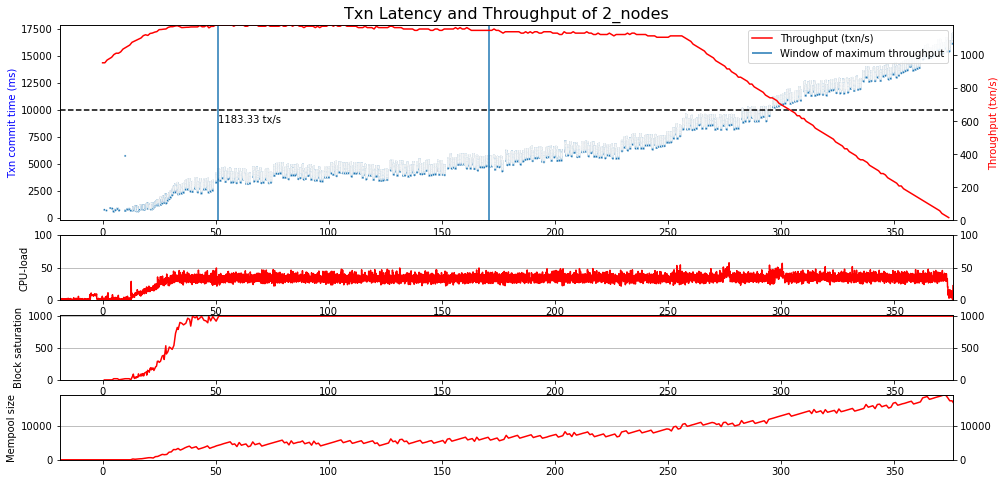

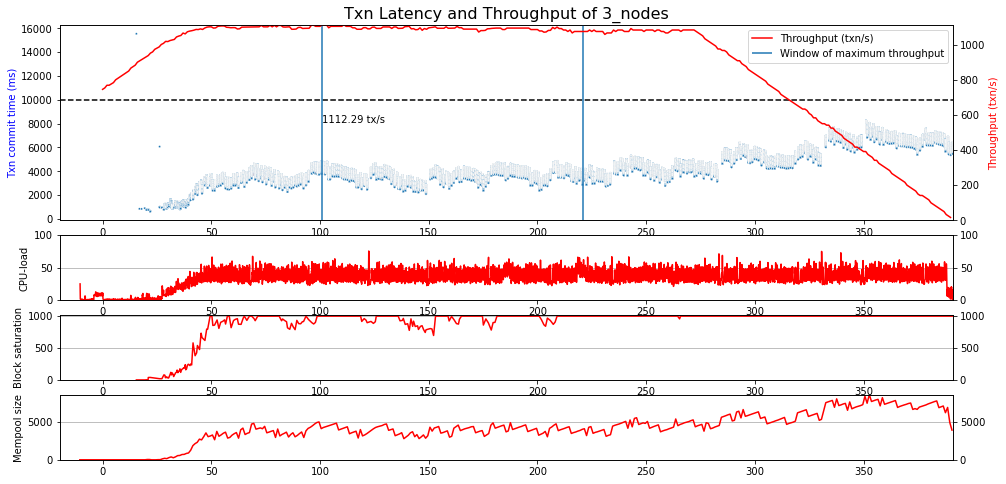

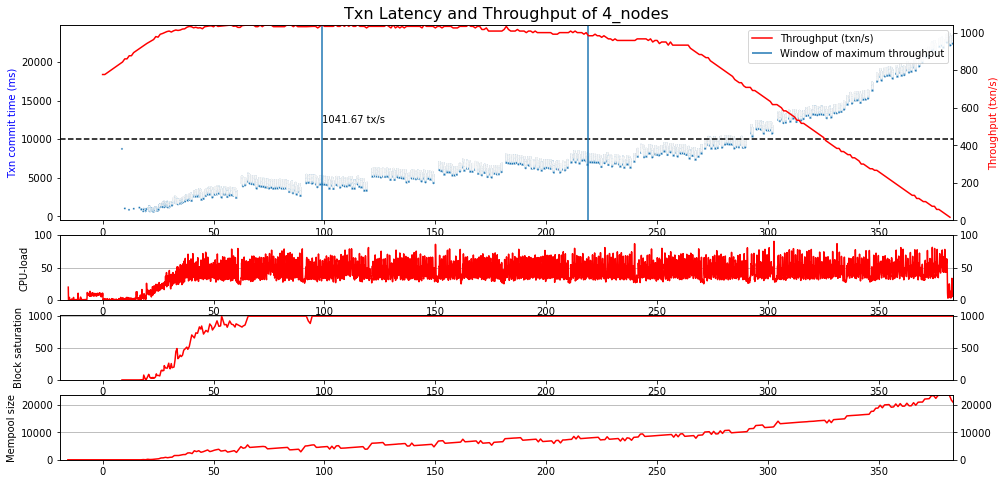

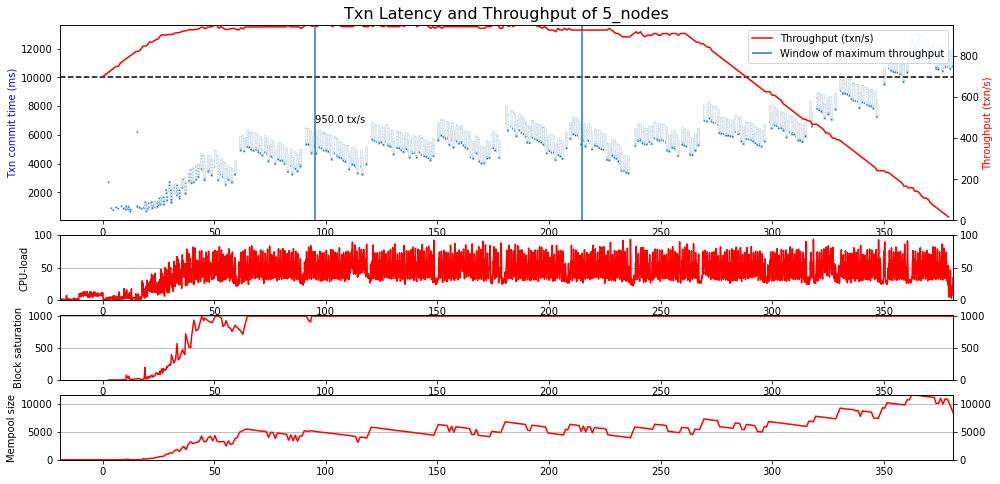

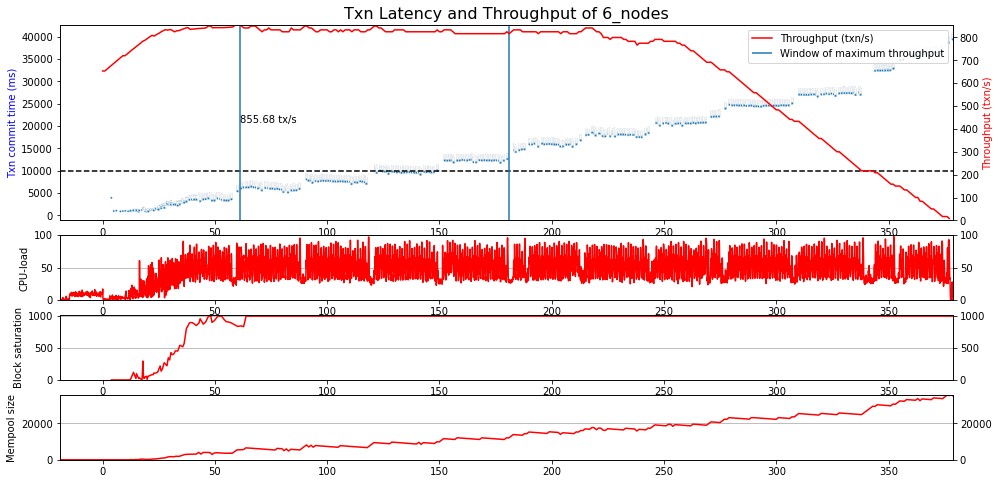

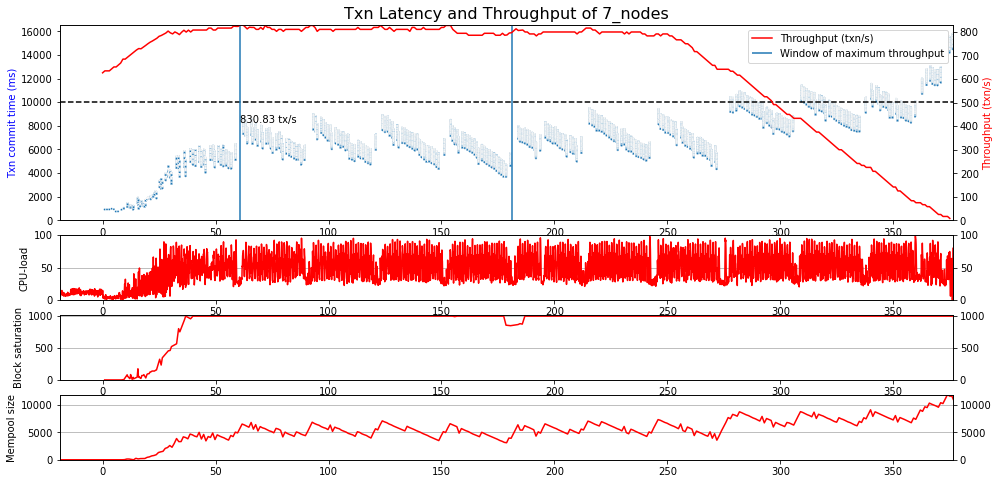

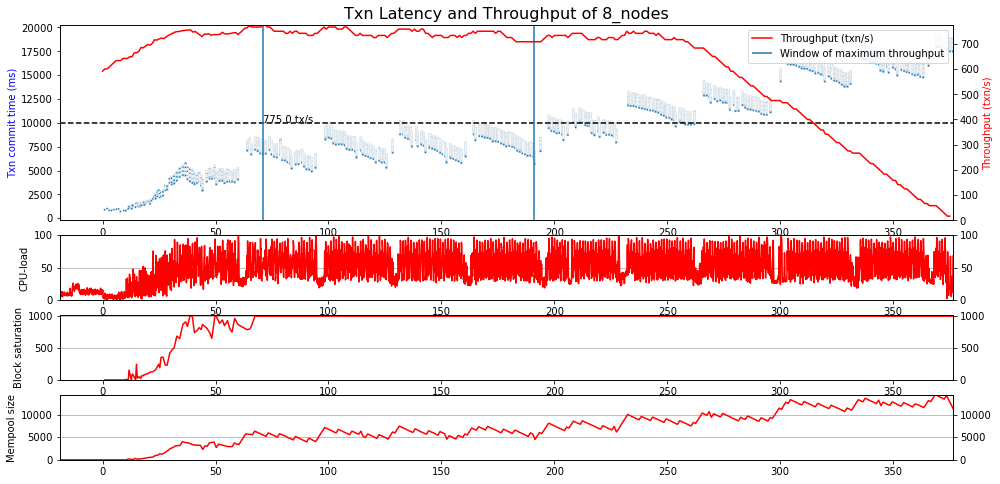

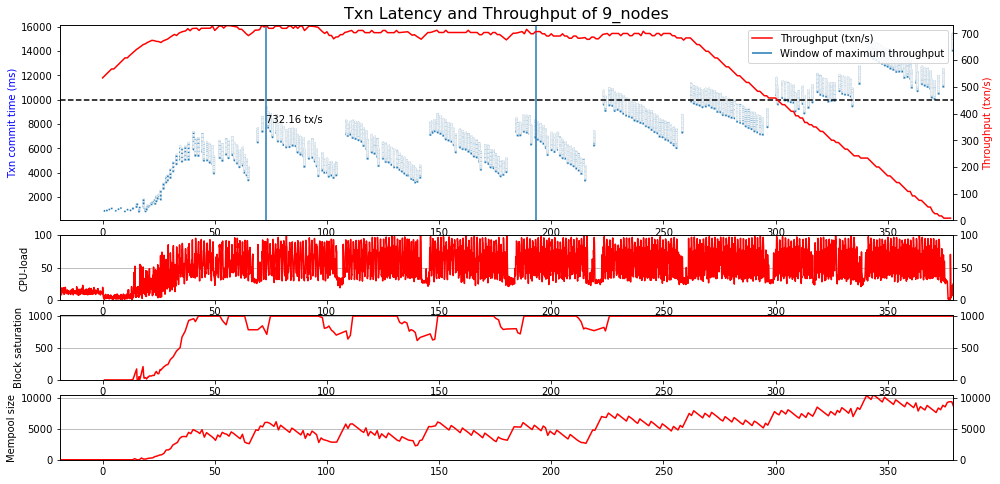

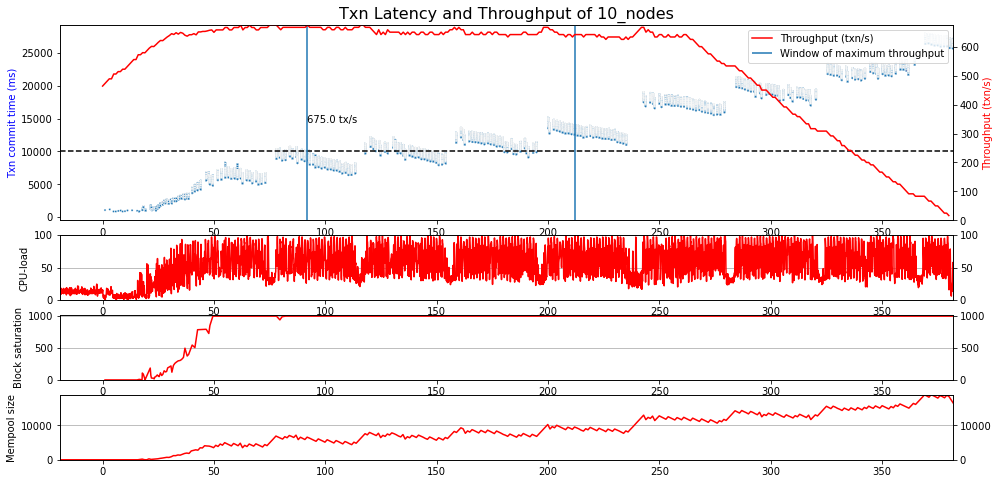

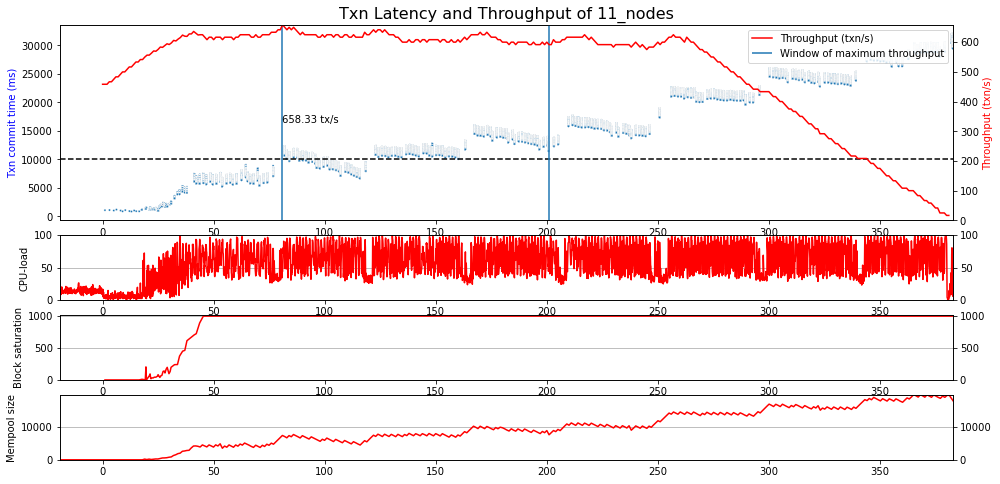

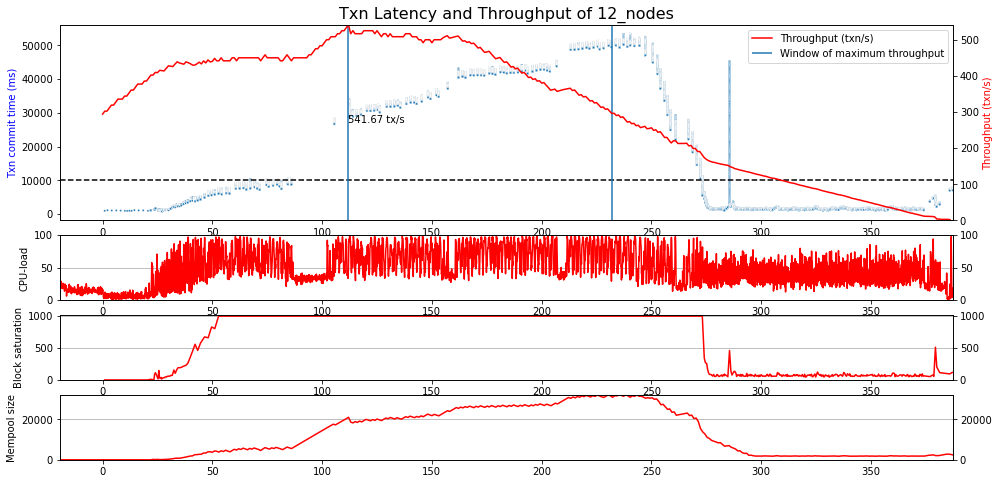

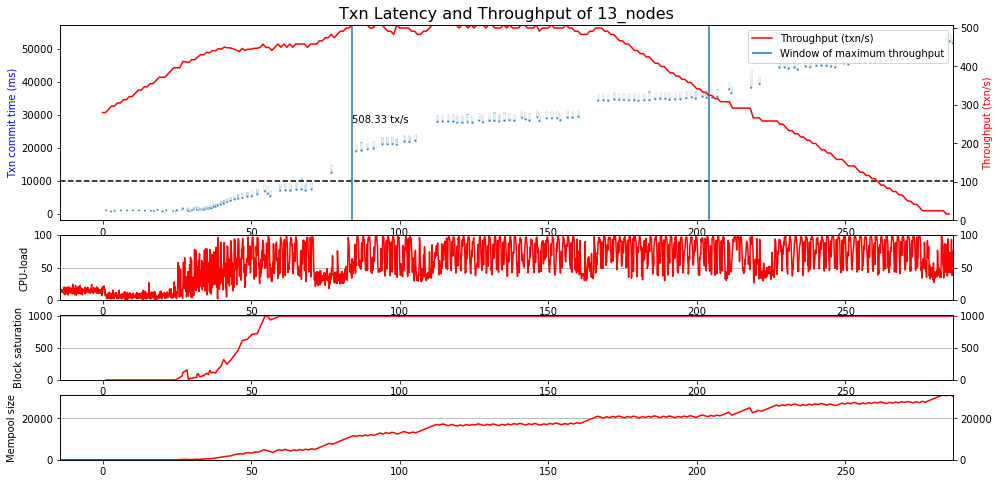

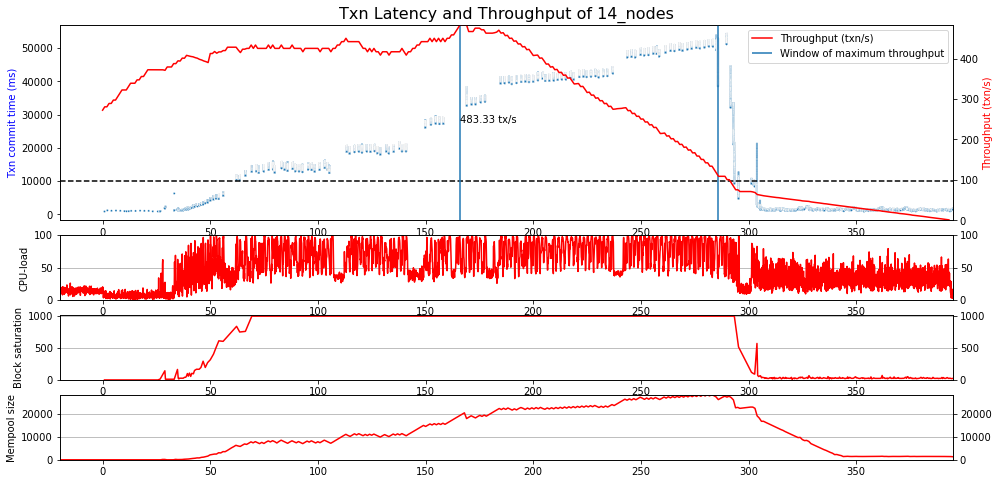

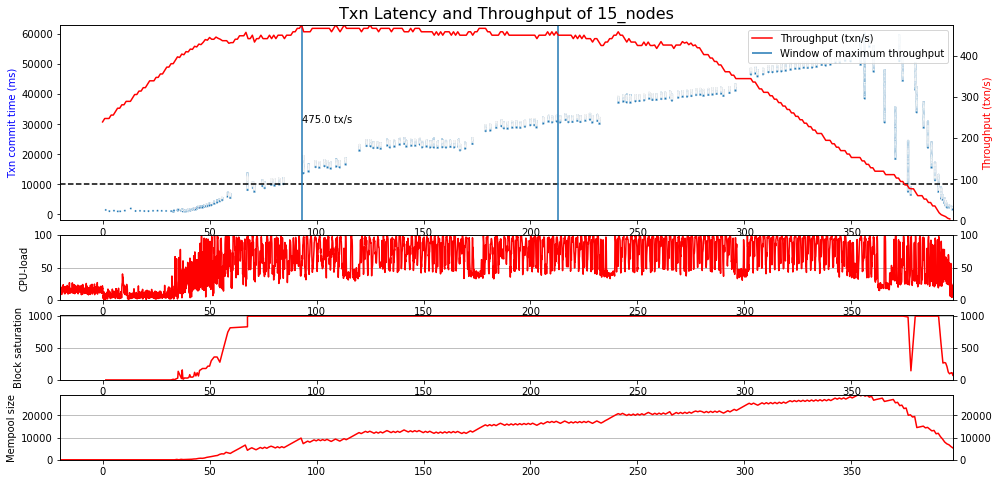

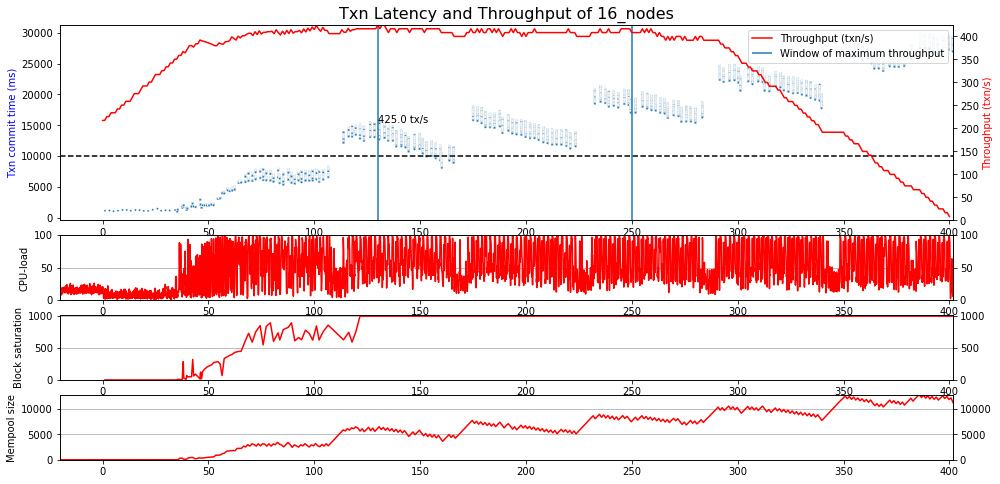

In [11]:
# Print the result graphs for experiment1
#directory_exp1 = '/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment1_final_increasing/'
directory_exp1 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment1_constant/attempt6/'

time_window = 120

nr_nodes = []
nr_nodes_part1 = []
nr_nodes_part2 = []

for x_nodes in os.listdir(directory_exp1):
    nr_nodes_part1.append(int(x_nodes.split('_')[0]))
    nr_nodes_part2.append(str(x_nodes.split('_')[1]))

nr_nodes_part1.sort()
for node_nr in range(len(nr_nodes_part1)):
    nr_nodes.append(str(nr_nodes_part1[node_nr]) + "_" + nr_nodes_part2[node_nr])

max_throughput_experiment1 = []
for x_nodes in nr_nodes:
    for experiment_folder in os.listdir(directory_exp1 + x_nodes):
        directory_tmp = directory_exp1 + x_nodes + "/" + experiment_folder + "/"
        blockstore_dataframe, block_saturation = get_blockstore_dataframe_and_block_saturation(directory_tmp)
        max_throughput_tmp = plot_throughput_commit_times(blockstore_dataframe, directory_tmp, block_saturation, time_window, "Txn Latency and Throughput of " + x_nodes)
        max_throughput_experiment1.append(x_nodes + "=" + str(int(max_throughput_tmp)))
        break
        
for line in max_throughput_experiment1:
    print(line)

10_delay=941
30_delay=950
50_delay=954
70_delay=929
90_delay=847
110_delay=858
130_delay=885
150_delay=857
170_delay=845
190_delay=806
210_delay=806
230_delay=33
250_delay=21


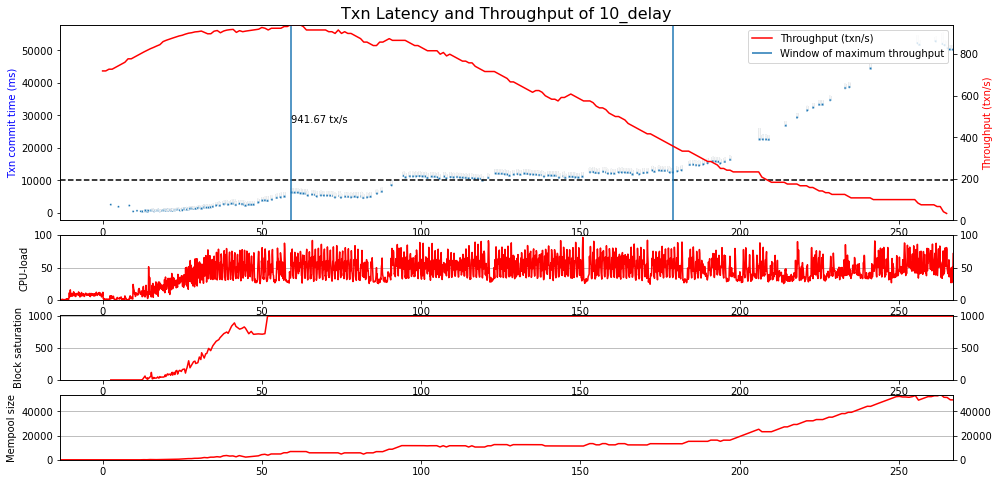

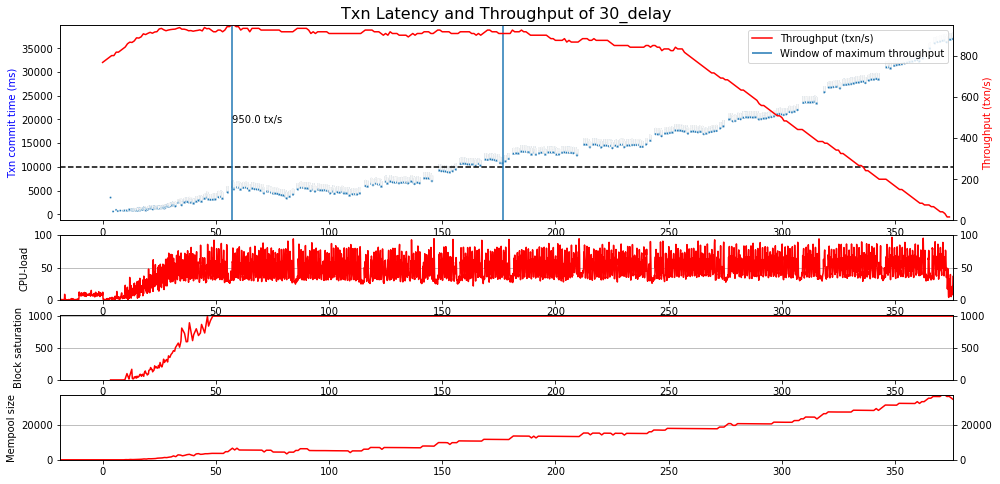

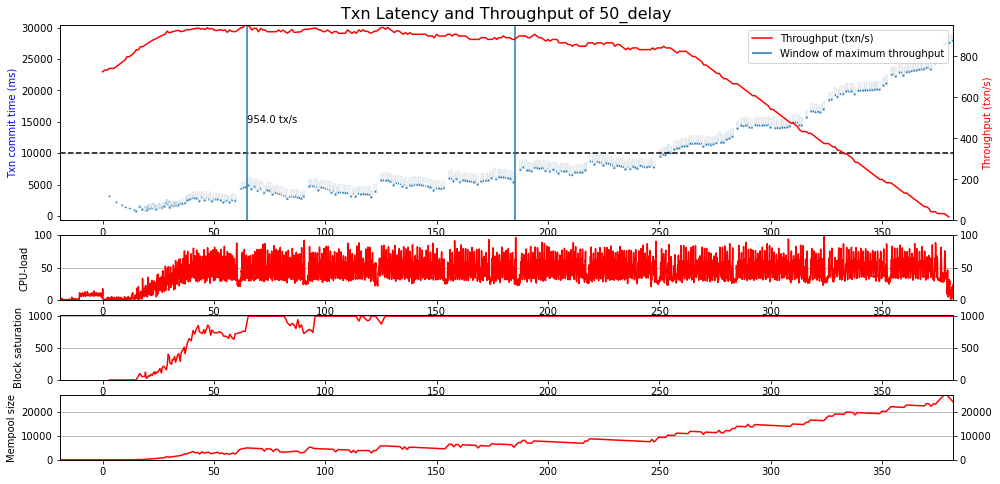

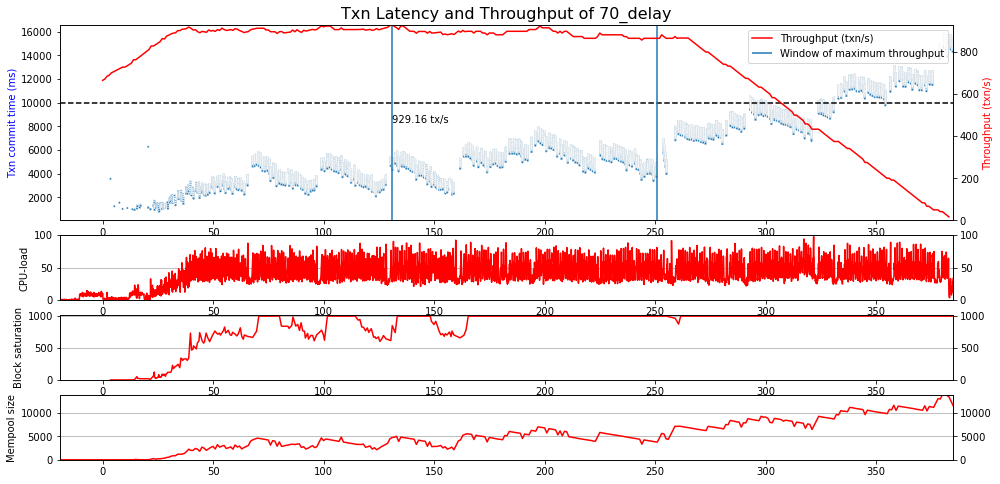

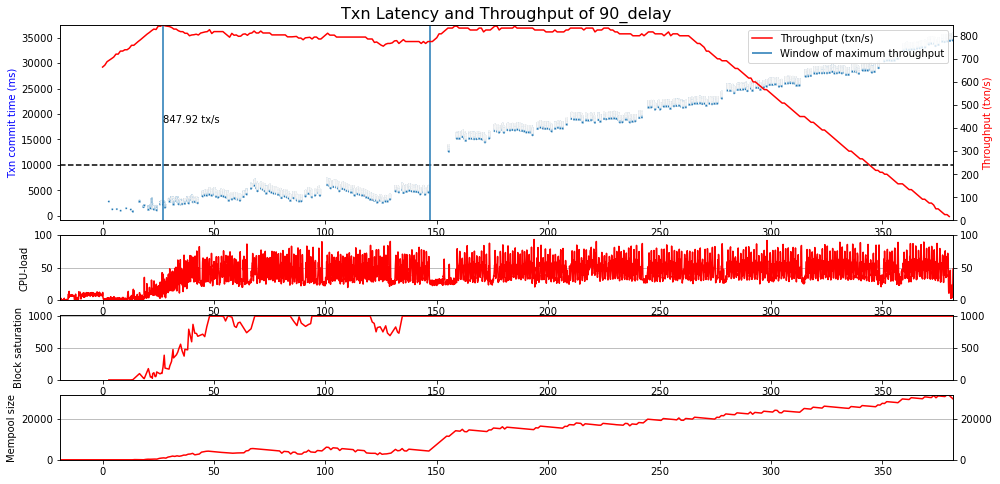

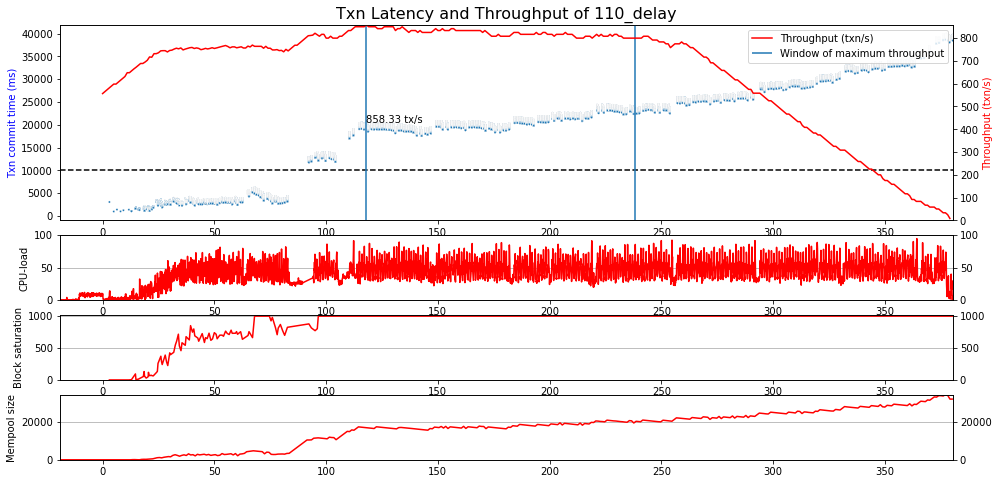

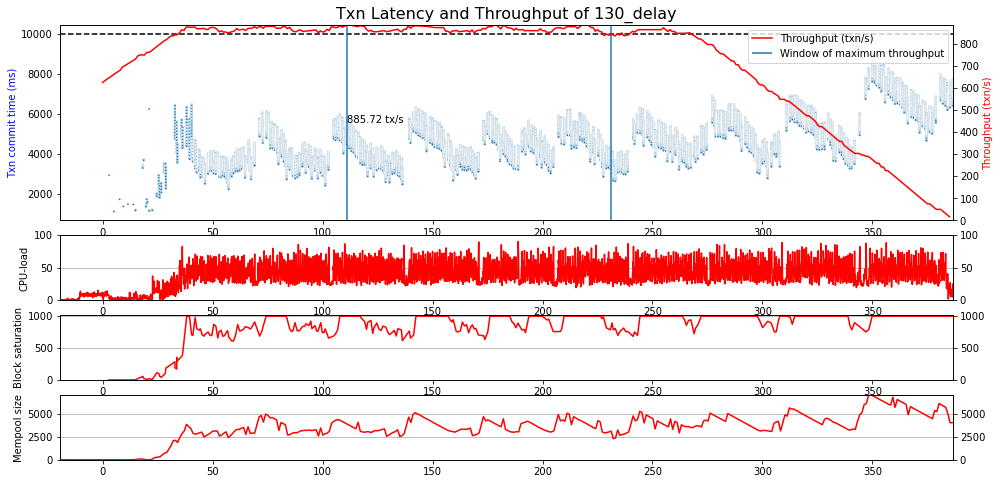

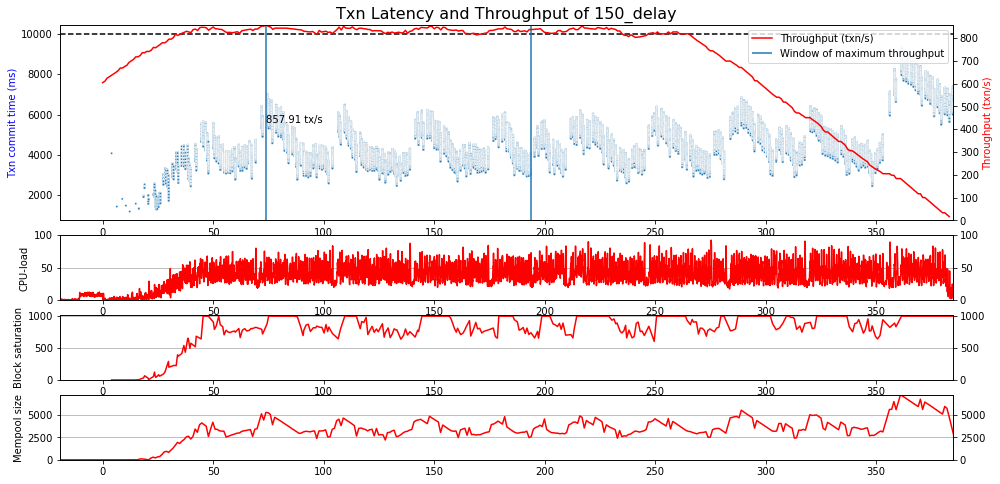

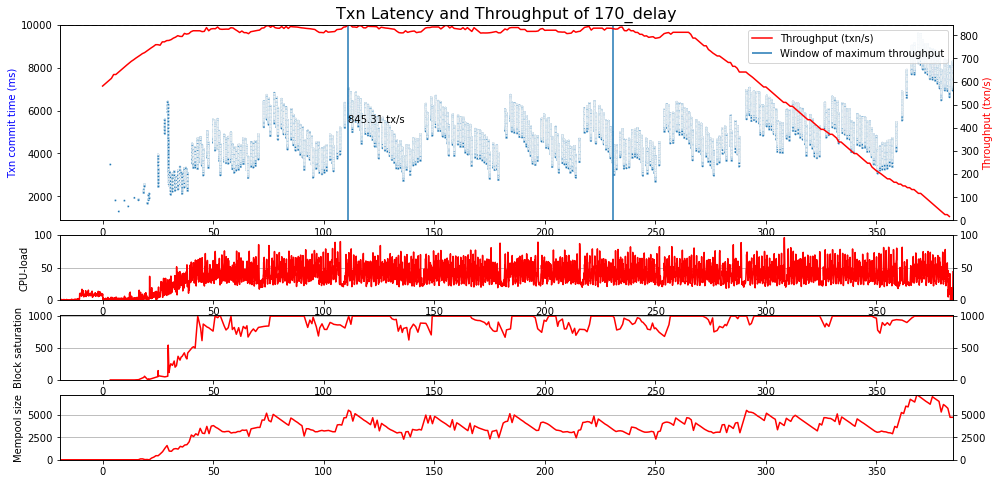

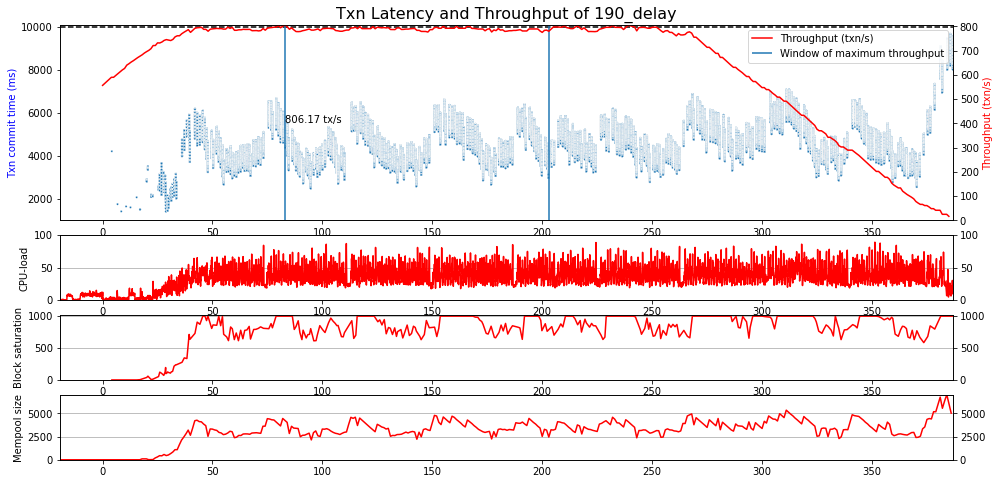

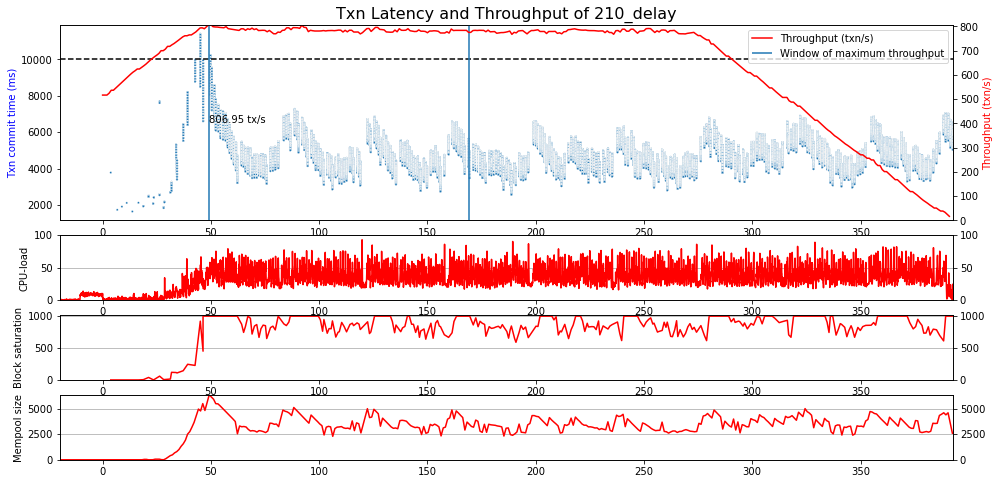

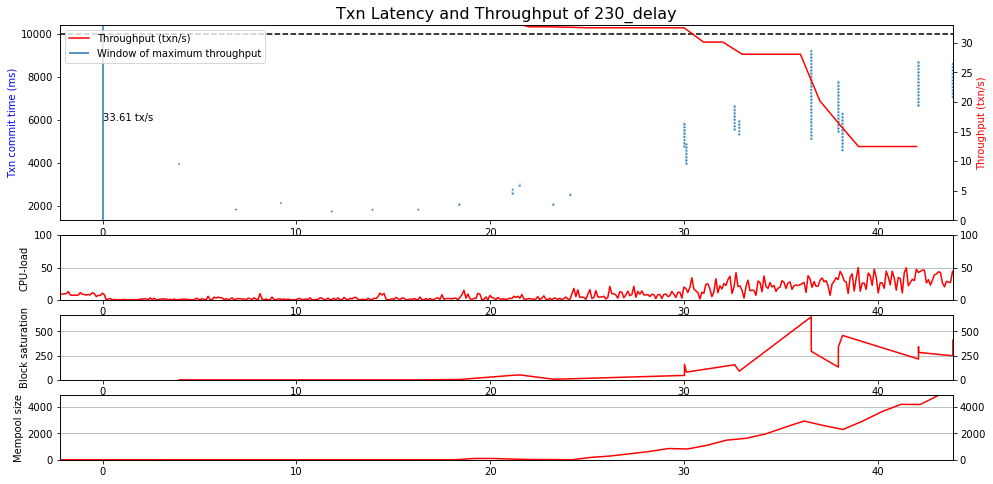

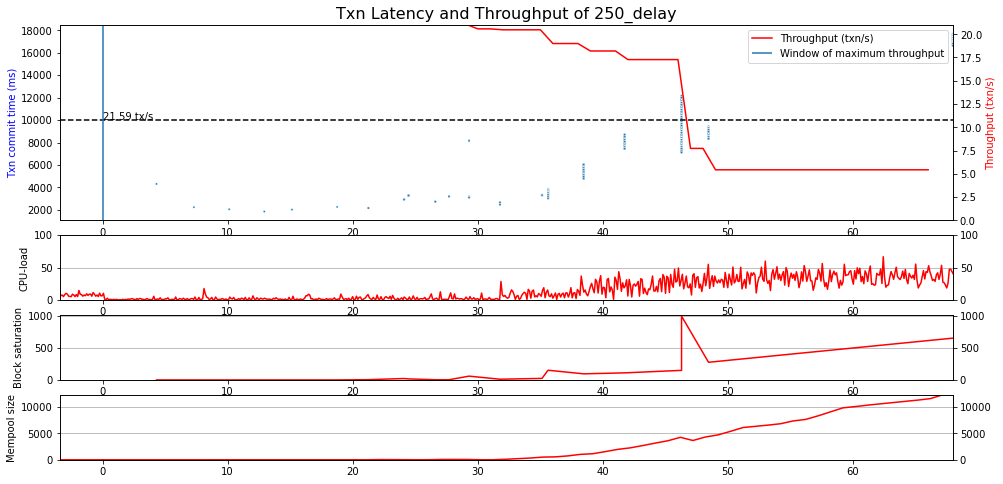

In [12]:
# Print the result graphs for experiment2
#directory_exp2 = '/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment2_final_increasing/'
directory_exp2 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment2_constant/attempt6/'
time_window = 120

nr_nodes = []
nr_nodes_part1 = []
nr_nodes_part2 = []

for x_nodes in os.listdir(directory_exp2):
    nr_nodes_part1.append(int(x_nodes.split('_')[0]))
    nr_nodes_part2.append(str(x_nodes.split('_')[1]))

nr_nodes_part1.sort()
for node_nr in range(len(nr_nodes_part1)):
    nr_nodes.append(str(nr_nodes_part1[node_nr]) + "_" + nr_nodes_part2[node_nr])

max_throughput_experiment2 = []
for x_nodes in nr_nodes:
    for experiment_folder in os.listdir(directory_exp2 + x_nodes):
        directory_tmp = directory_exp2 + x_nodes + "/" + experiment_folder + "/"
        blockstore_dataframe, block_saturation = get_blockstore_dataframe_and_block_saturation(directory_tmp)
        max_throughput_tmp = plot_throughput_commit_times(blockstore_dataframe, directory_tmp, block_saturation, time_window, "Txn Latency and Throughput of " + x_nodes)
        max_throughput_experiment2.append(x_nodes + "=" + str(int(max_throughput_tmp)))
        break
        
for line in max_throughput_experiment2:
    print(line)

10_bandwidth=762
20_bandwidth=867
30_bandwidth=884
40_bandwidth=913
50_bandwidth=908
60_bandwidth=929
70_bandwidth=914
80_bandwidth=925
90_bandwidth=908
100_bandwidth=927
200_bandwidth=951
300_bandwidth=958
400_bandwidth=958
500_bandwidth=960


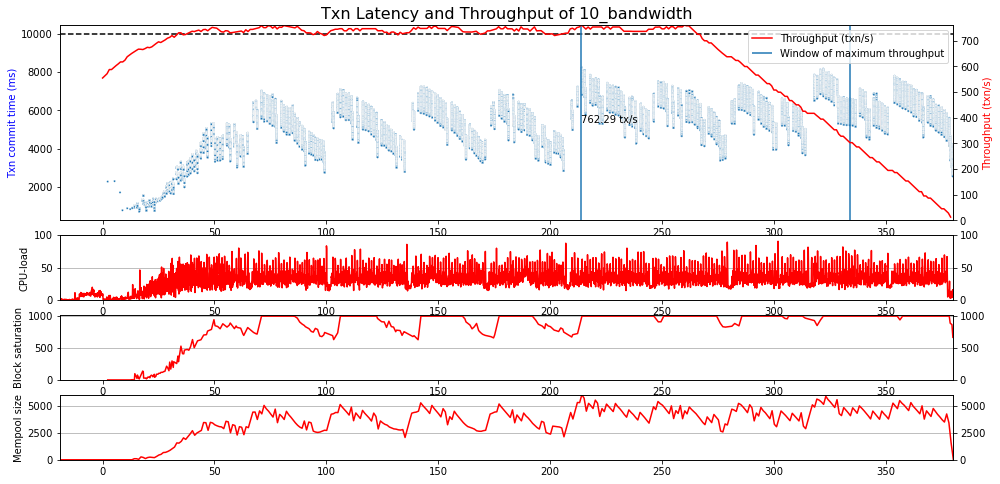

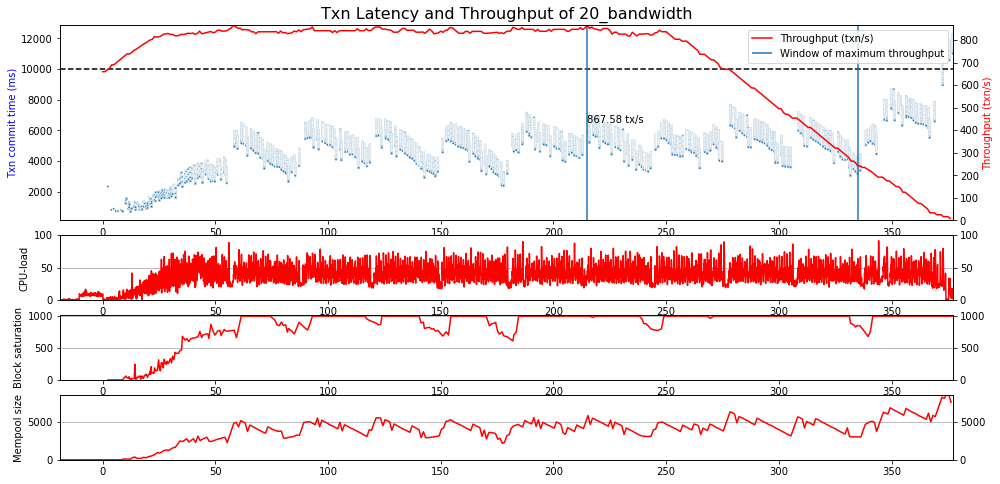

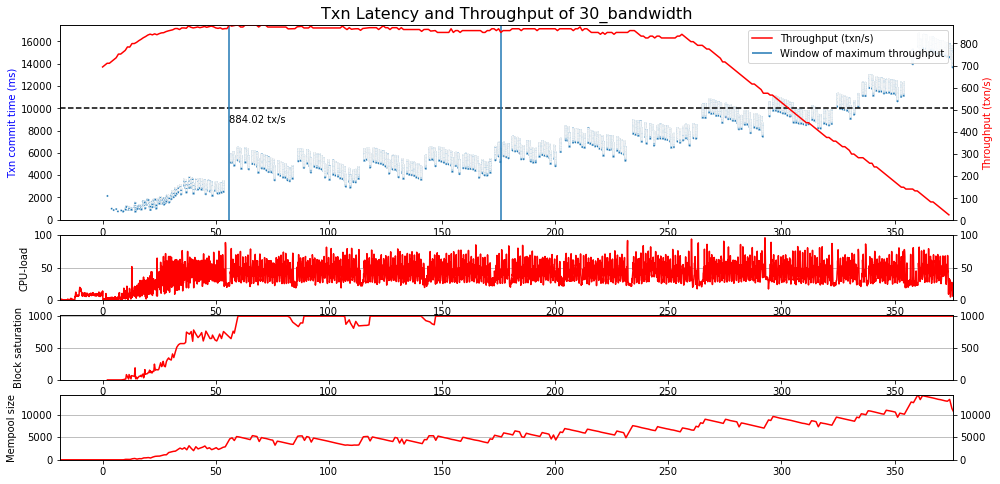

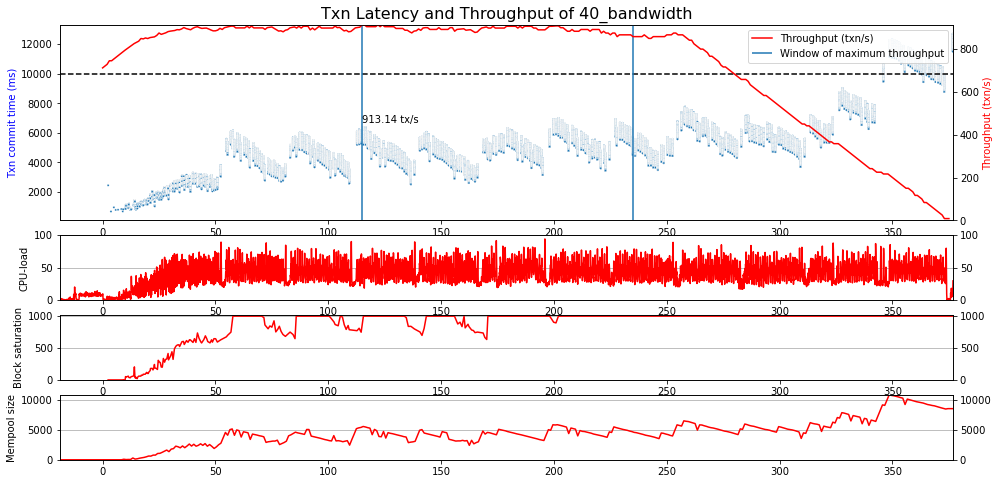

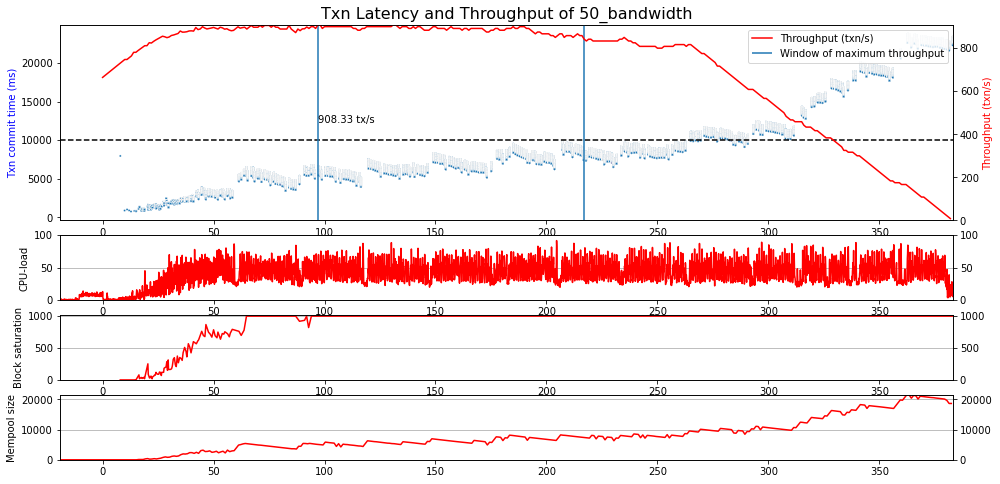

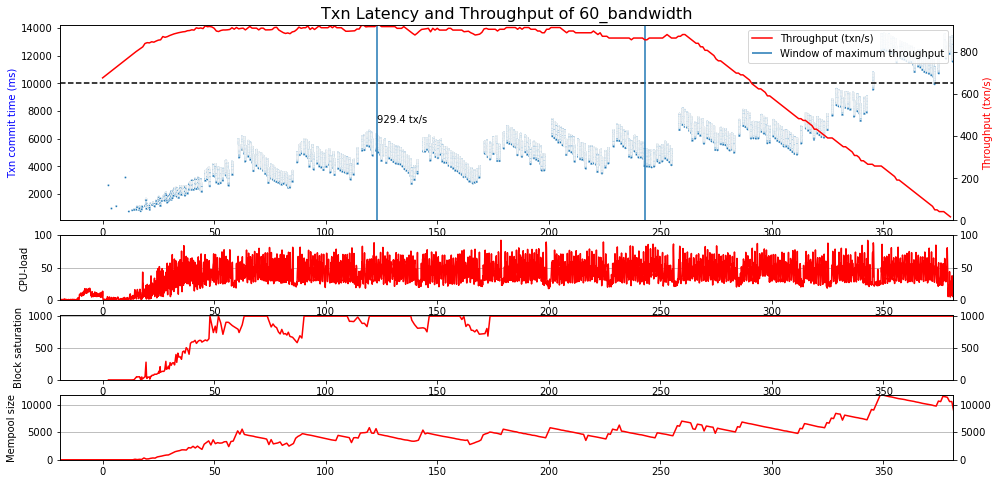

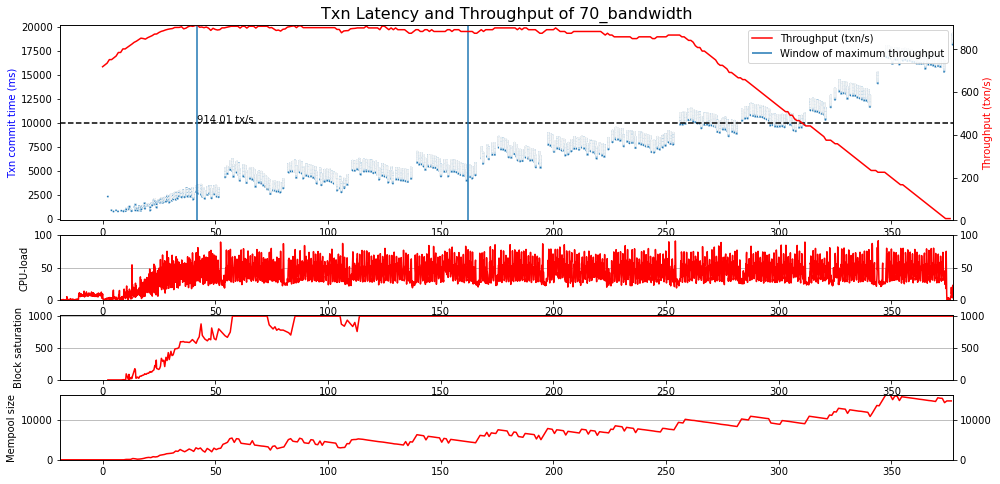

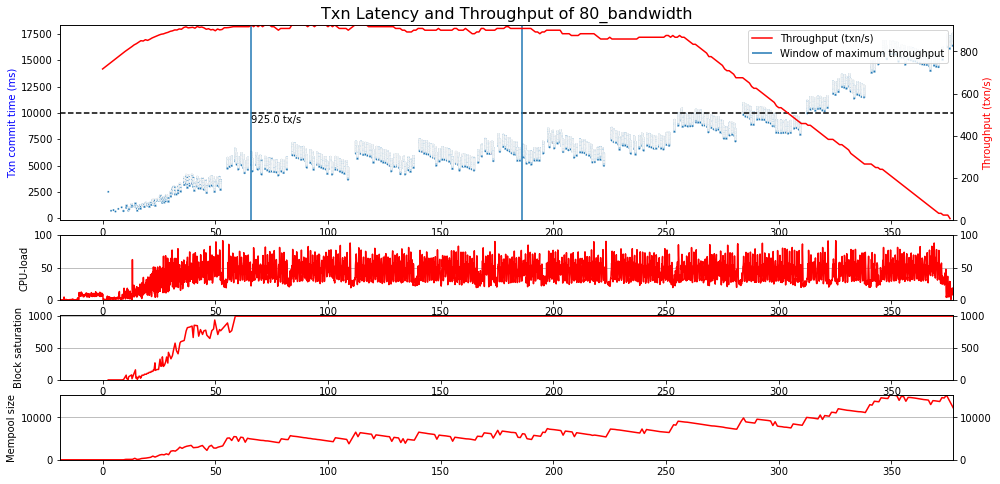

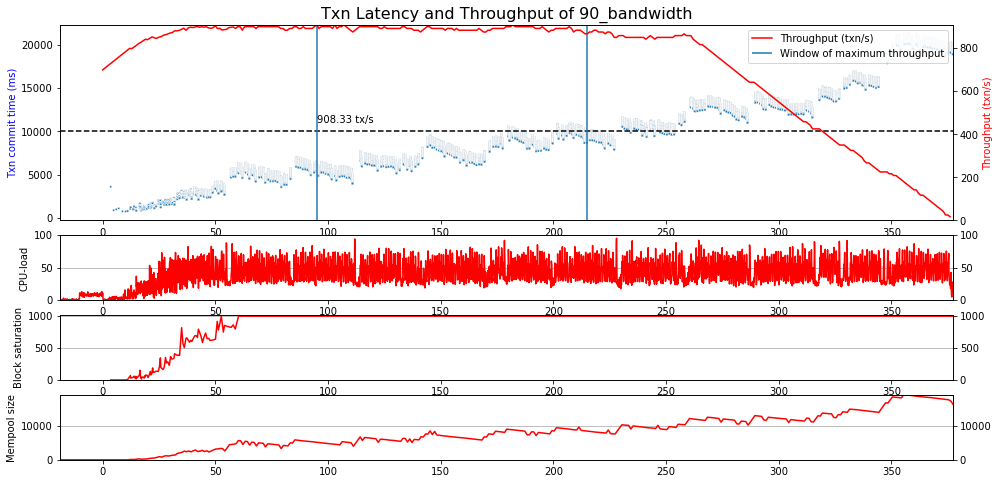

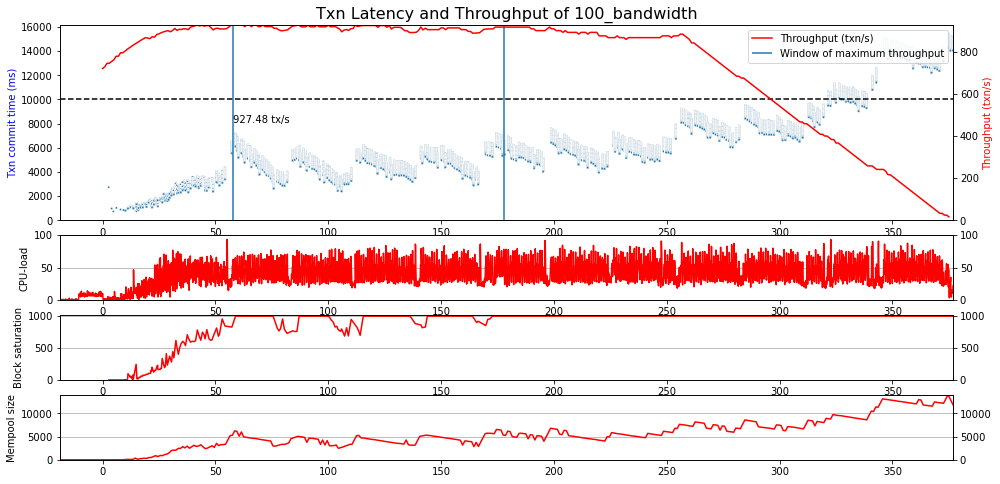

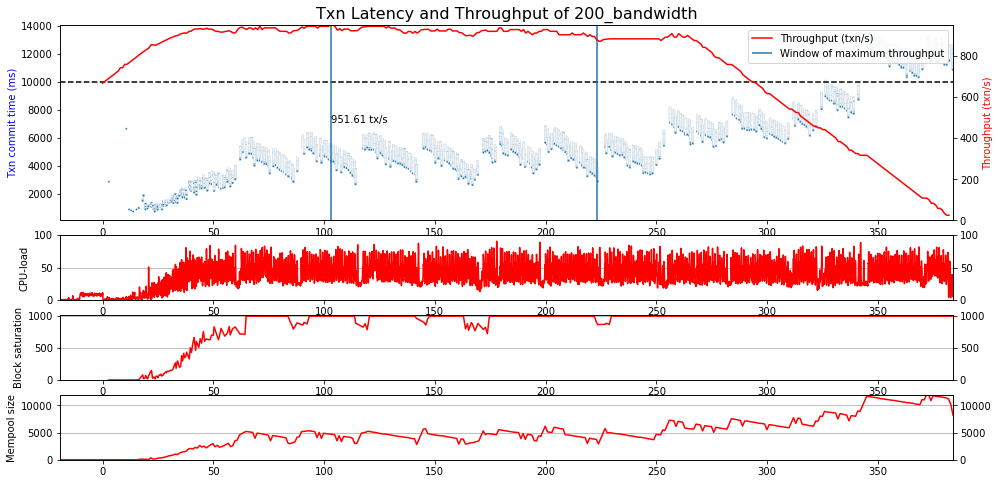

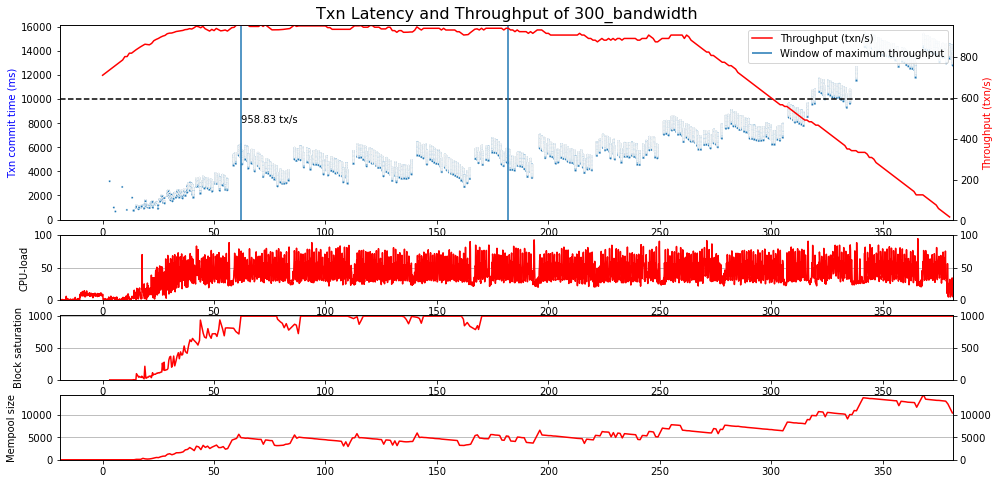

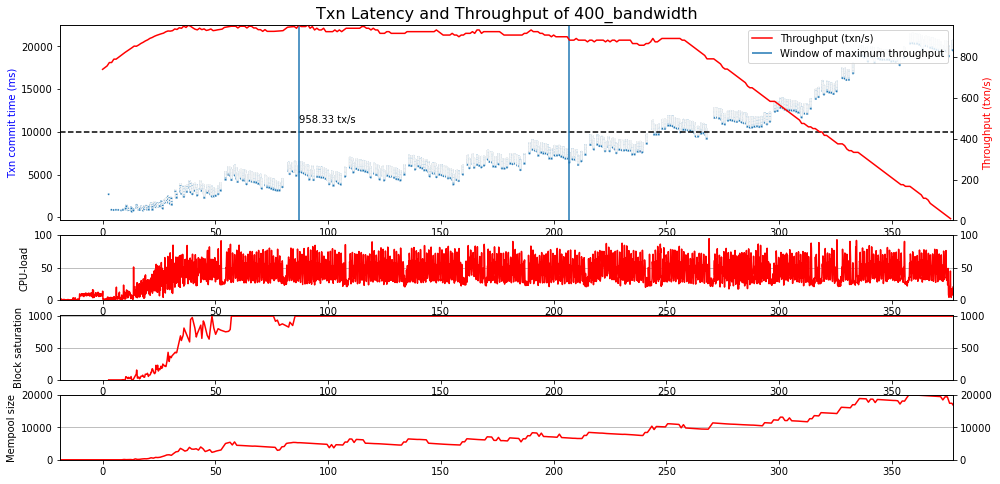

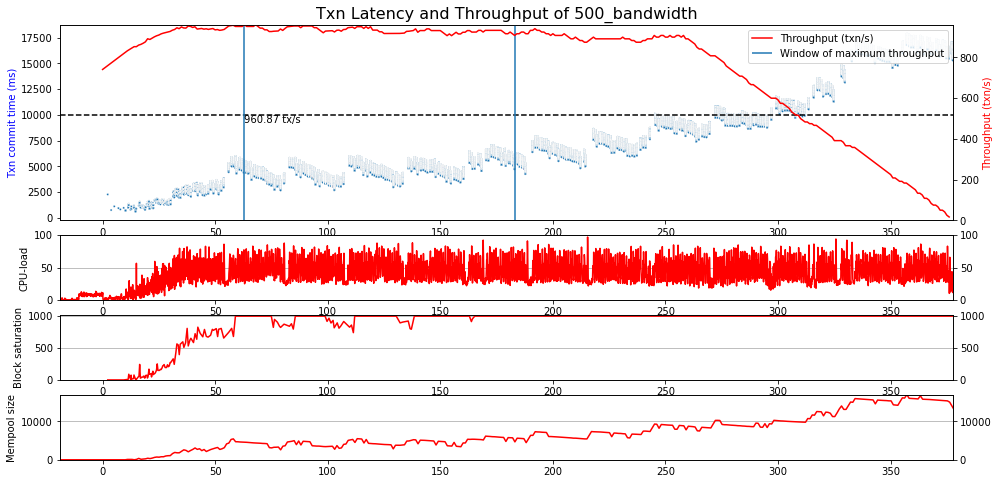

In [13]:
# Print the result graphs for experiment3
directory_exp3 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment3_constant/attempt6/'
#directory_exp3 = '/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment3/'
time_window = 120

nr_nodes = []
nr_nodes_part1 = []
nr_nodes_part2 = []

for x_nodes in os.listdir(directory_exp3):
    nr_nodes_part1.append(int(x_nodes.split('_')[0]))
    nr_nodes_part2.append(str(x_nodes.split('_')[1]))

nr_nodes_part1.sort()
for node_nr in range(len(nr_nodes_part1)):
    nr_nodes.append(str(nr_nodes_part1[node_nr]) + "_" + nr_nodes_part2[node_nr])

max_throughput_experiment3 = []
for x_nodes in nr_nodes:
    for experiment_folder in os.listdir(directory_exp3 + x_nodes):
        directory_tmp = directory_exp3 + x_nodes + "/" + experiment_folder + "/"
        blockstore_dataframe, block_saturation = get_blockstore_dataframe_and_block_saturation(directory_tmp)
        max_throughput_tmp = plot_throughput_commit_times(blockstore_dataframe, directory_tmp, block_saturation, time_window, "Txn Latency and Throughput of " + x_nodes)
        max_throughput_experiment3.append(x_nodes + "=" + str(int(max_throughput_tmp)))
        break
        
for line in max_throughput_experiment3:
    print(line)

100_blocksize=355
200_blocksize=533
300_blocksize=664
400_blocksize=730
500_blocksize=805
600_blocksize=859
700_blocksize=904
800_blocksize=956
900_blocksize=961
1000_blocksize=977
1500_blocksize=1037
2000_blocksize=1054


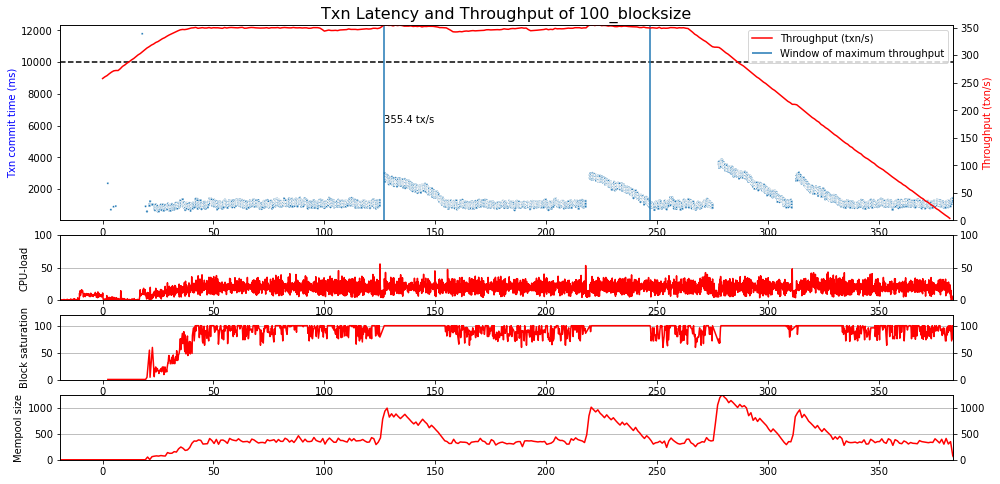

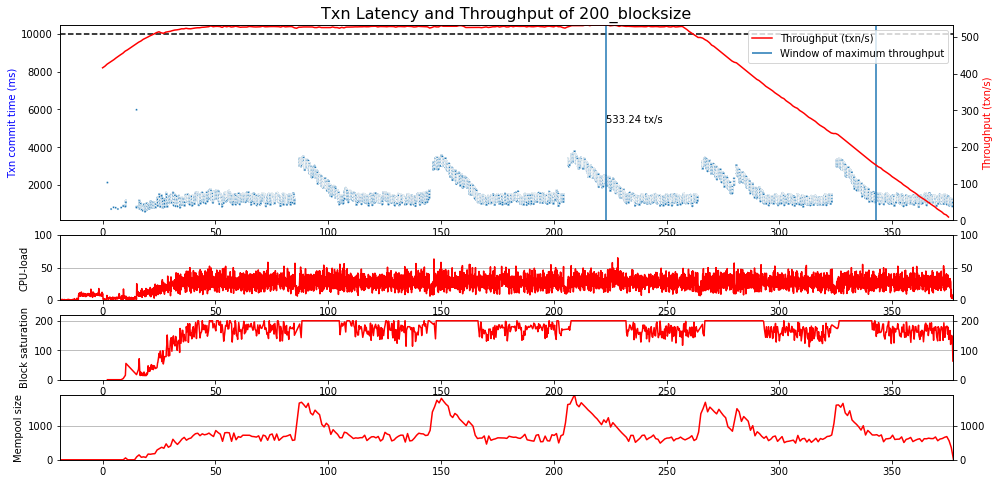

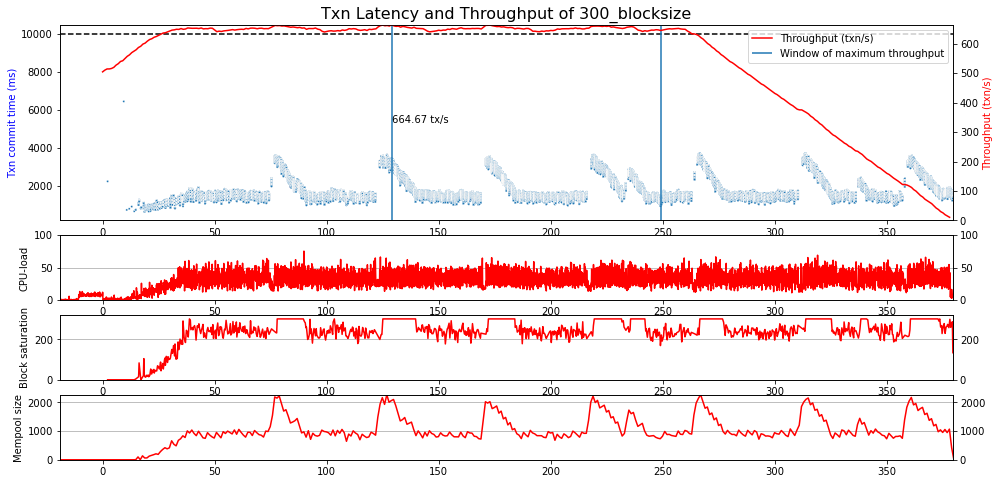

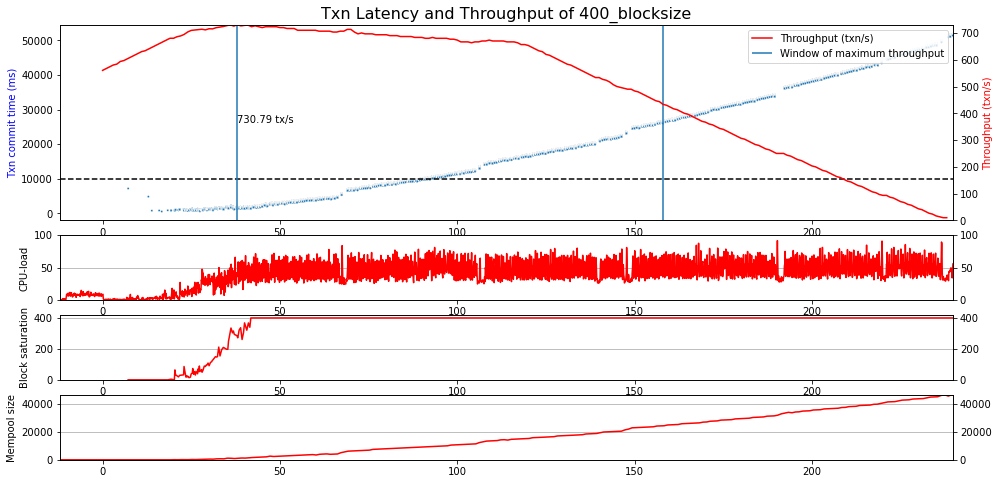

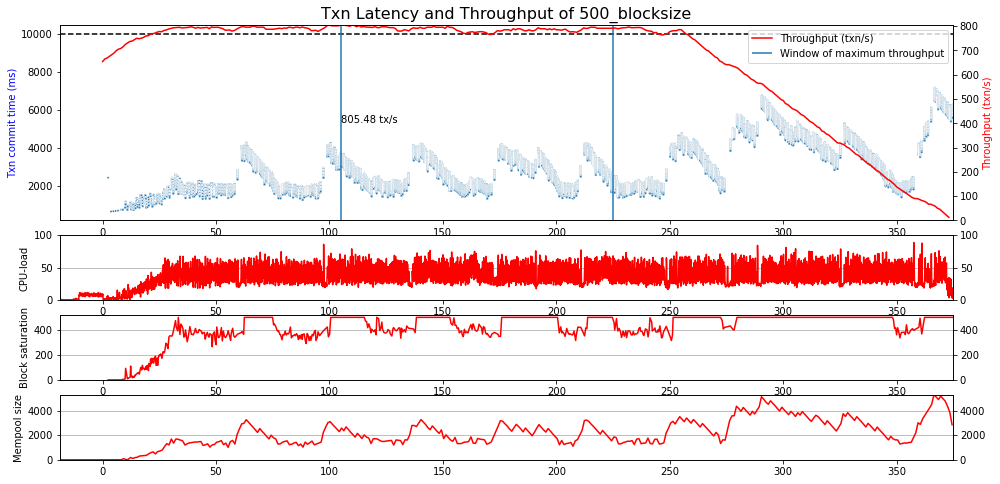

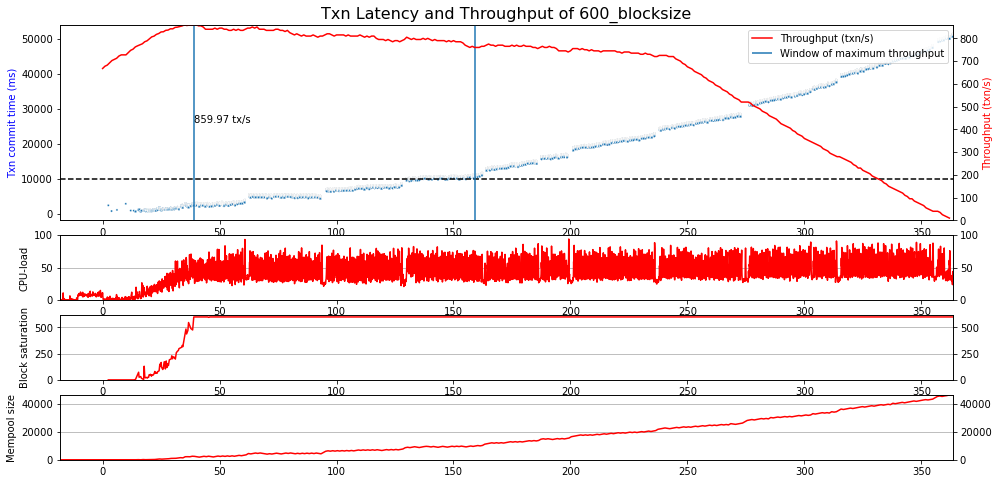

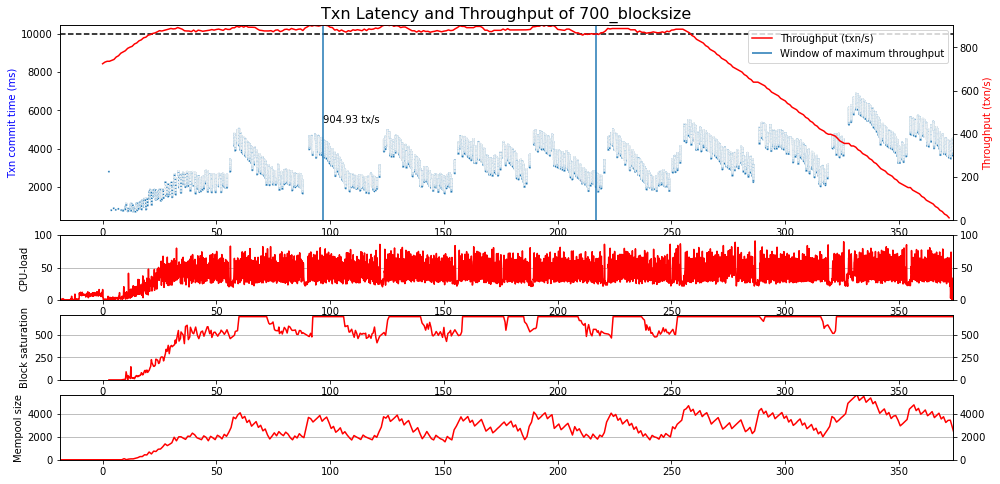

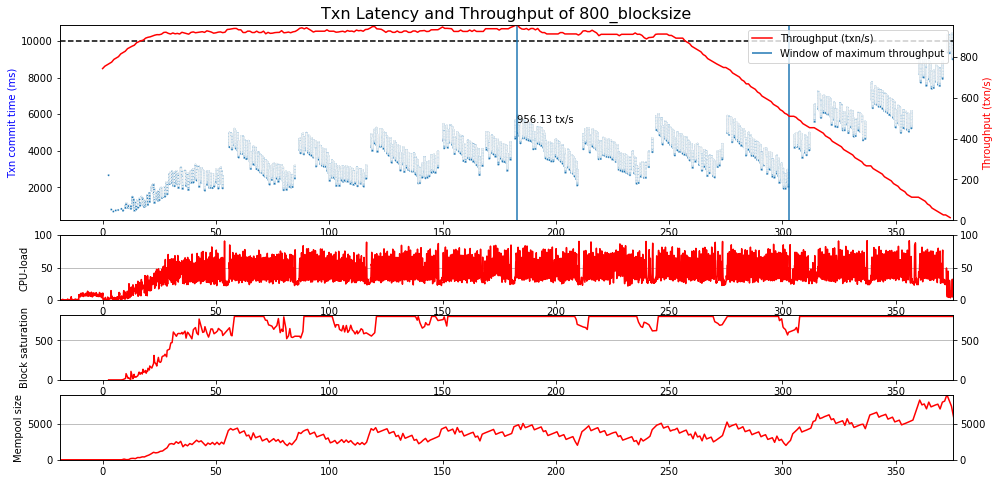

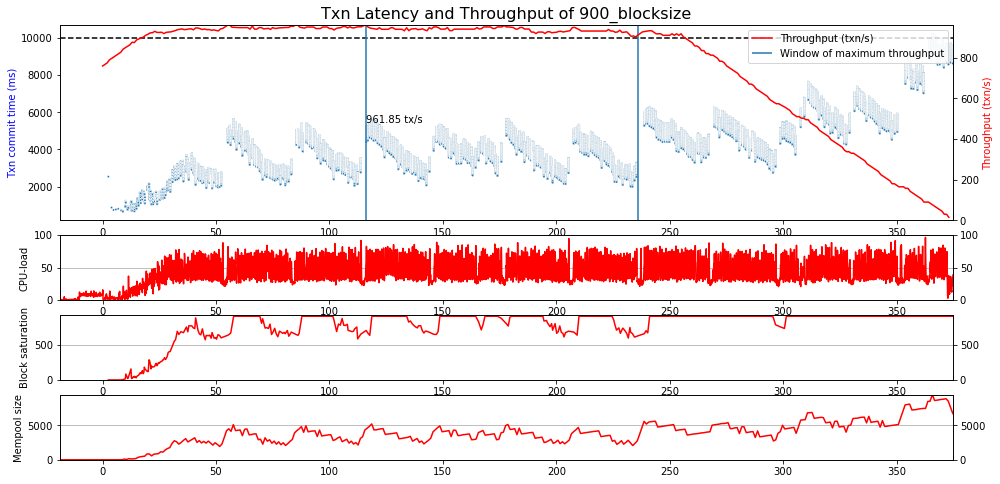

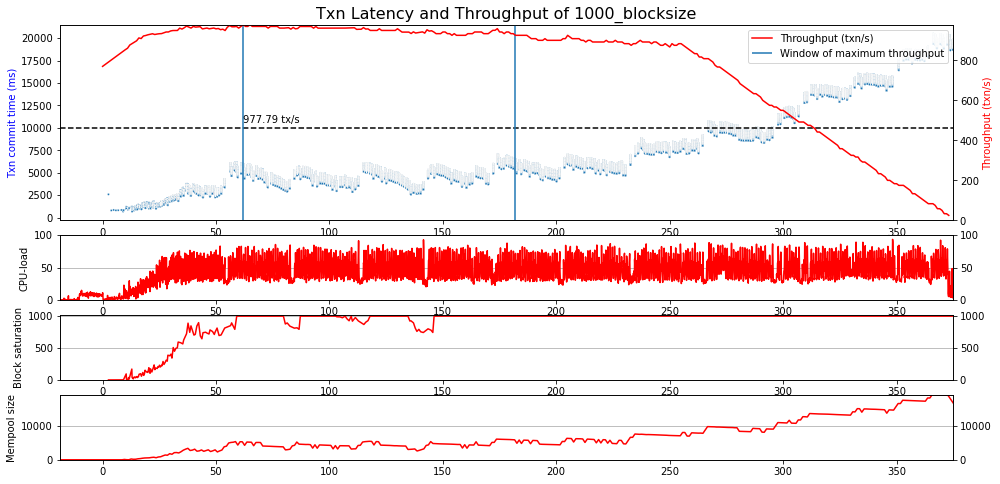

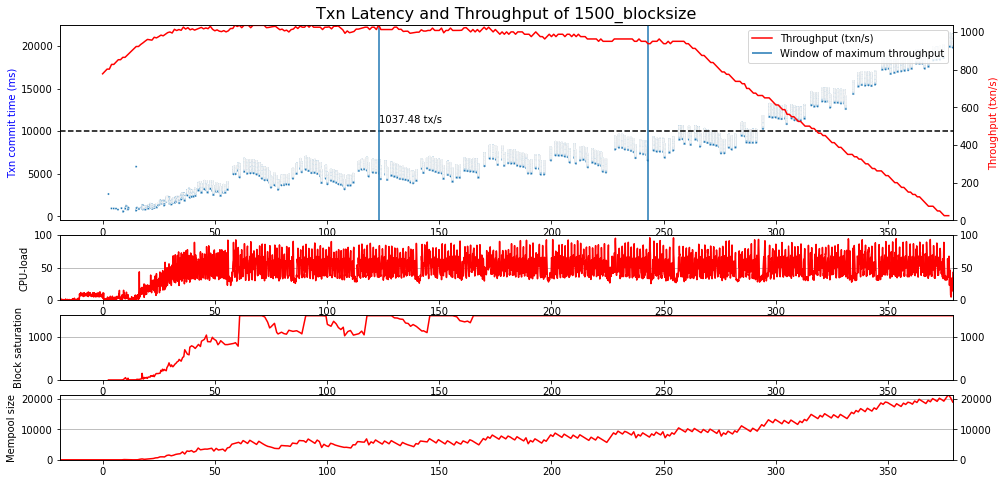

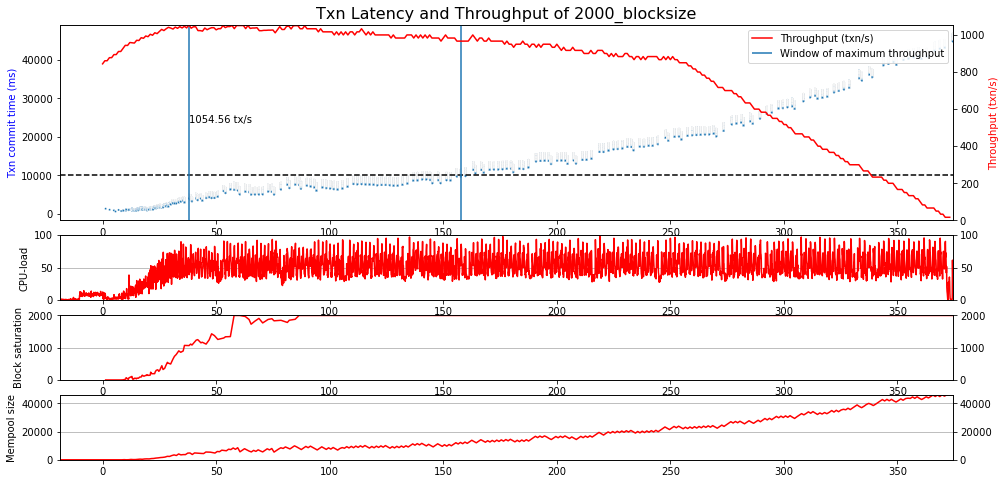

In [14]:
# Print the result graphs for experiment4
directory_exp4 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment4_constant/attempt6/'
#directory_exp4 = '/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment4_final_increasing/'
time_window = 120

nr_nodes = []
nr_nodes_part1 = []
nr_nodes_part2 = []

for x_nodes in os.listdir(directory_exp4):
    nr_nodes_part1.append(int(x_nodes.split('_')[0]))
    nr_nodes_part2.append(str(x_nodes.split('_')[1]))

nr_nodes_part1.sort()
for node_nr in range(len(nr_nodes_part1)):
    nr_nodes.append(str(nr_nodes_part1[node_nr]) + "_" + nr_nodes_part2[node_nr])

max_throughput_experiment4 = []
for x_nodes in nr_nodes:
    for experiment_folder in os.listdir(directory_exp4 + x_nodes):
        directory_tmp = directory_exp4 + x_nodes + "/" + experiment_folder + "/"
        blockstore_dataframe, block_saturation = get_blockstore_dataframe_and_block_saturation(directory_tmp)
        max_throughput_tmp = plot_throughput_commit_times(blockstore_dataframe, directory_tmp, block_saturation, time_window, "Txn Latency and Throughput of " + x_nodes)
        max_throughput_experiment4.append(x_nodes + "=" + str(int(max_throughput_tmp)))
        break
        
for line in max_throughput_experiment4:
    print(line)

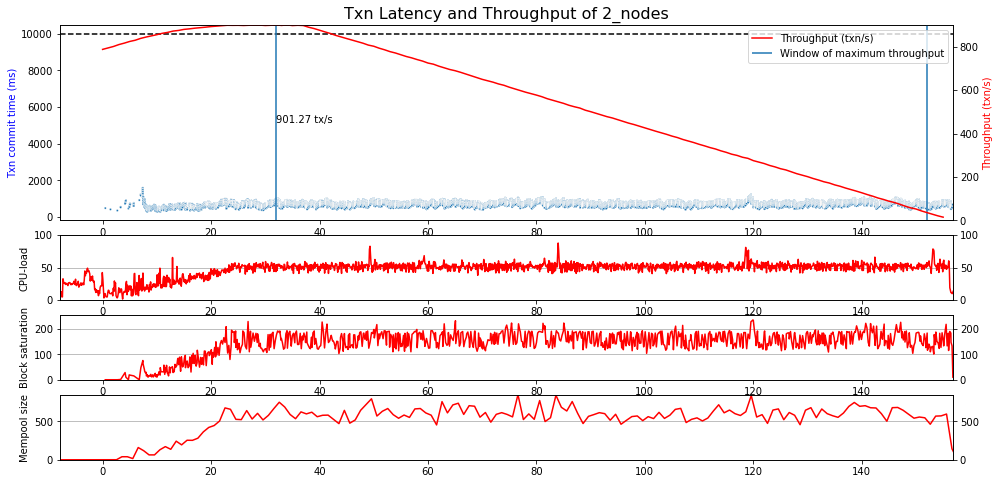

In [15]:
# Print the result graphs for experiment5
#directory_exp5 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment_vary_sending_interval/2_nodes/'
directory_exp5 = '/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment_compare_swarm_and_simulator/test_vary_timeout/'
time_window = 120

nr_nodes = []
nr_nodes_part1 = []
nr_nodes_part2 = []

for x_nodes in os.listdir(directory_exp5):
    nr_nodes_part1.append(int(x_nodes.split('_')[0]))
    nr_nodes_part2.append(str(x_nodes.split('_')[1]))

nr_nodes_part1.sort()
for node_nr in range(len(nr_nodes_part1)):
    nr_nodes.append(str(nr_nodes_part1[node_nr]) + "_" + nr_nodes_part2[node_nr])

max_throughput_experiment5 = []
for x_nodes in nr_nodes:
    for experiment_folder in os.listdir(directory_exp5 + x_nodes):
        directory_tmp = directory_exp5 + x_nodes + "/" + experiment_folder + "/"
        blockstore_dataframe, block_saturation = get_blockstore_dataframe_and_block_saturation(directory_tmp)
            
        max_throughput_tmp = plot_throughput_commit_times(blockstore_dataframe, directory_tmp, block_saturation, time_window, "Txn Latency and Throughput of " + x_nodes)
        max_throughput_experiment5.append(x_nodes + "=" + str(int(max_throughput_tmp)))
        
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            block_saturation['timestamp_diff'] = block_saturation.diff(axis=0)['timestamp']
            #block_saturation = block_saturation[block_saturation['saturation'] == 1000]
            #print(block_saturation.describe())
            #print()
            #print(block_saturation)
            
        #break

Performance: (txns/s)
2_nodes=1544
3_nodes=1457
4_nodes=1390
5_nodes=1300
6_nodes=1244
7_nodes=1201
8_nodes=1127
9_nodes=1083
10_nodes=1033
11_nodes=1019
12_nodes=974
13_nodes=936
14_nodes=897
15_nodes=875
16_nodes=852
Max mempool size:
2_nodes=17960
3_nodes=17440
4_nodes=15588
5_nodes=18548
6_nodes=16080
7_nodes=21752
8_nodes=14048
9_nodes=16892
10_nodes=14204
11_nodes=21472
12_nodes=15848
13_nodes=13344
14_nodes=16144
15_nodes=12445
16_nodes=17338


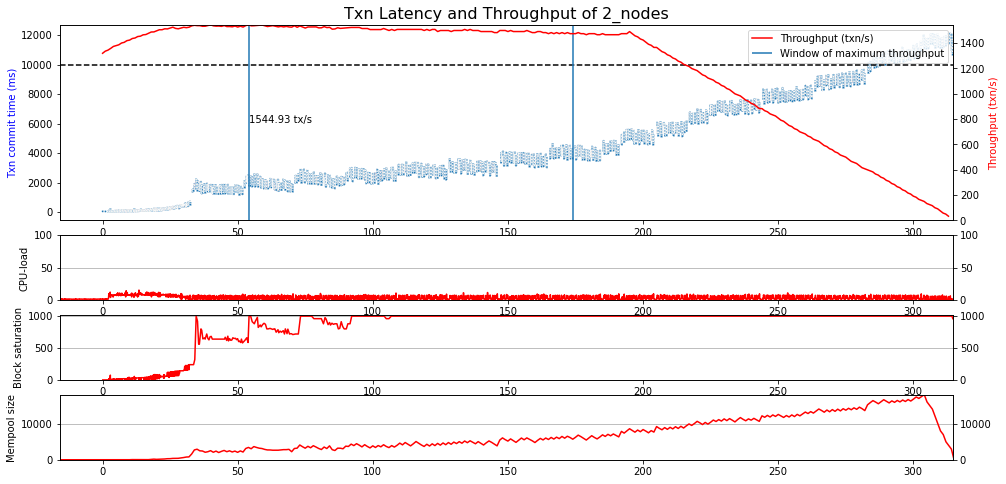

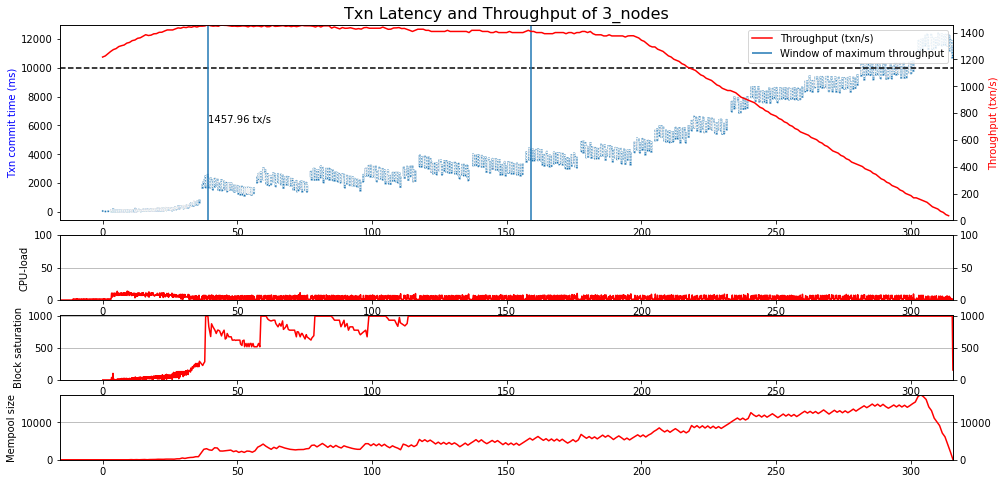

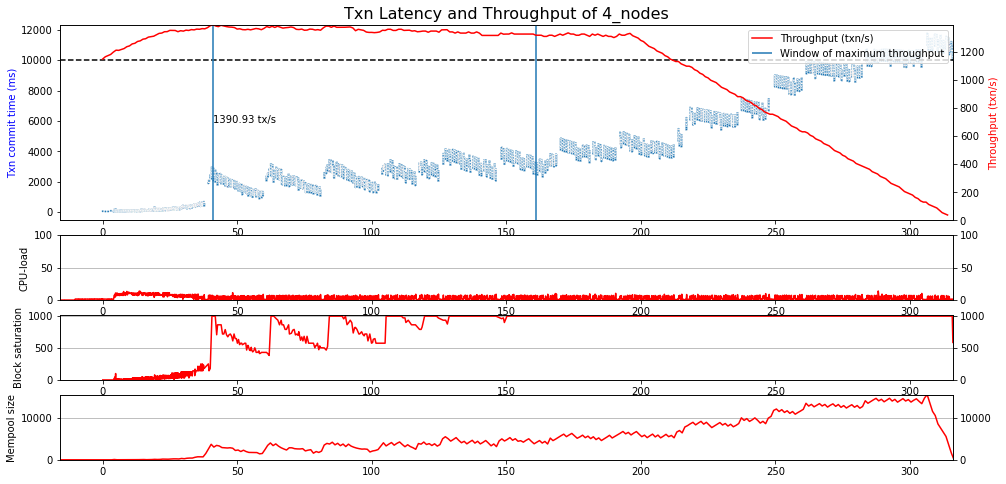

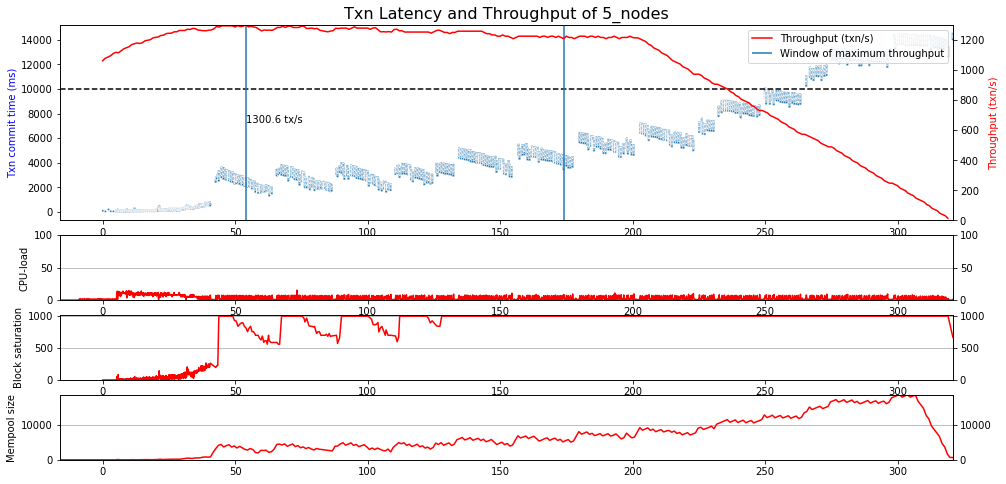

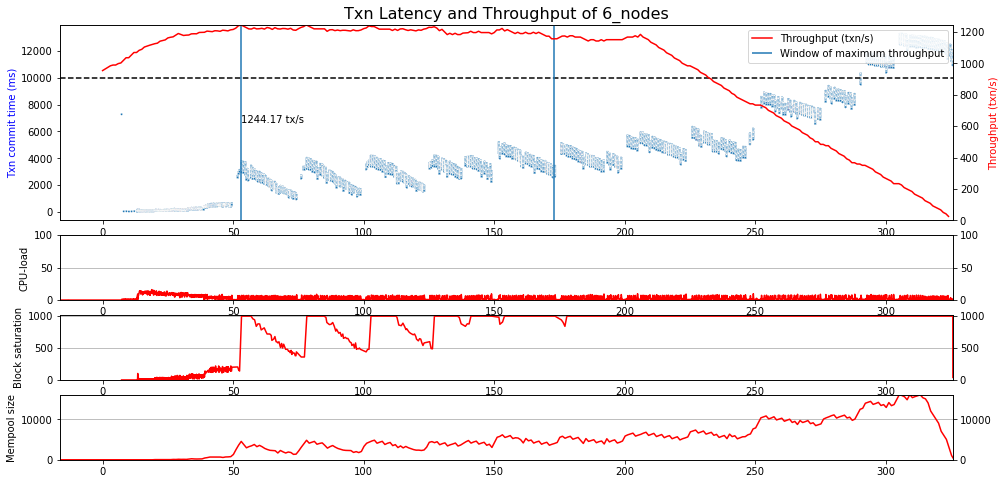

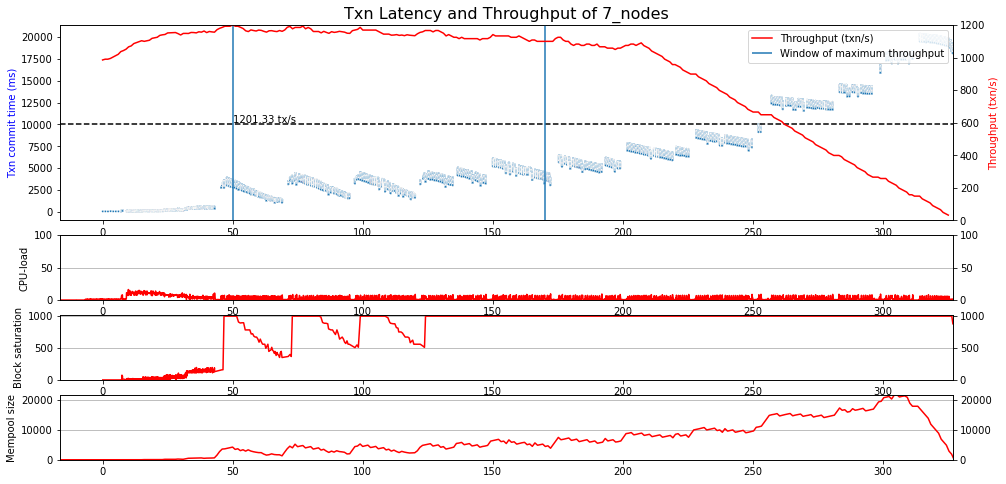

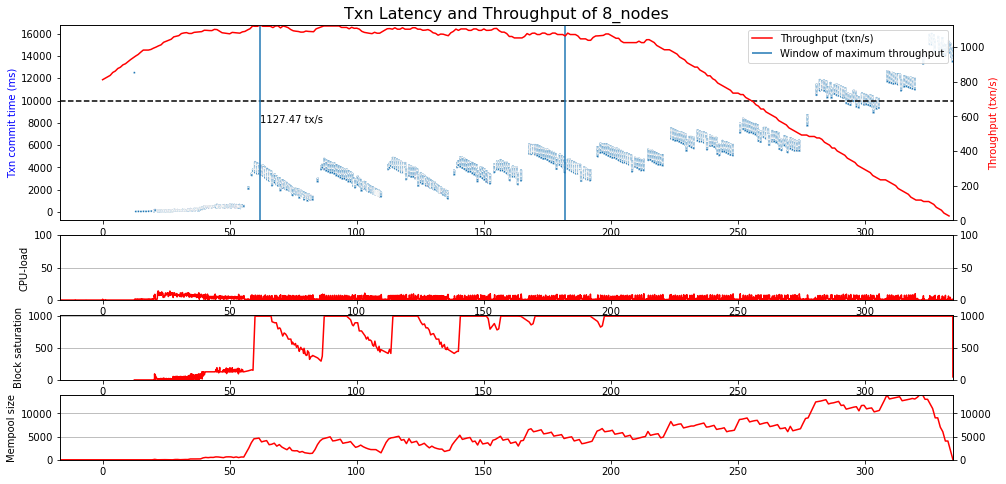

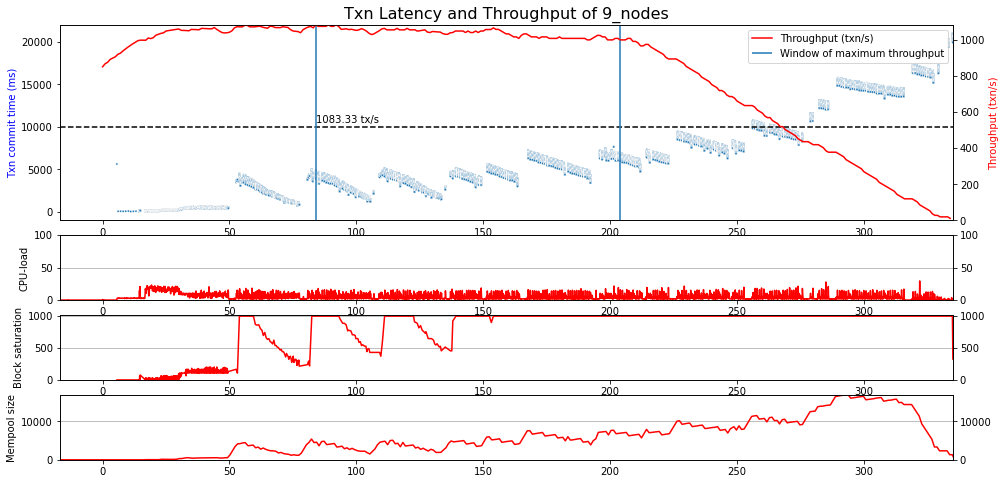

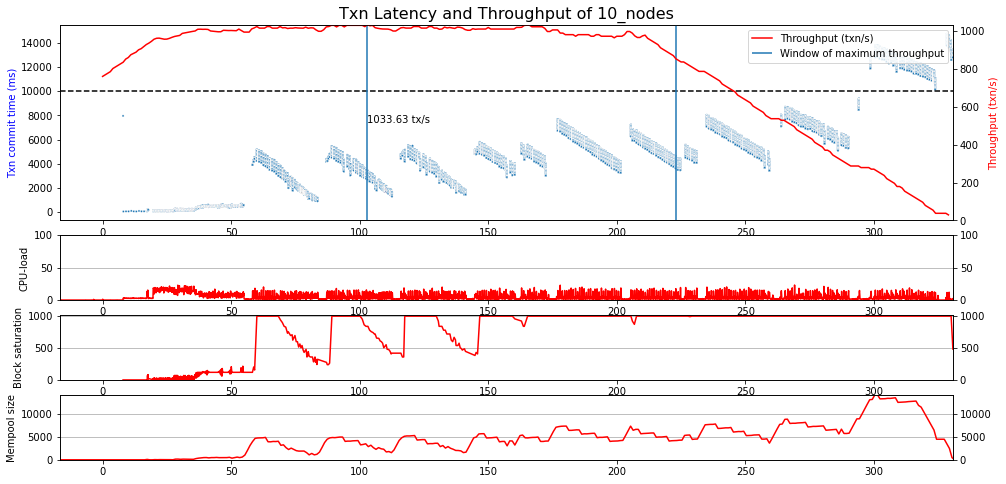

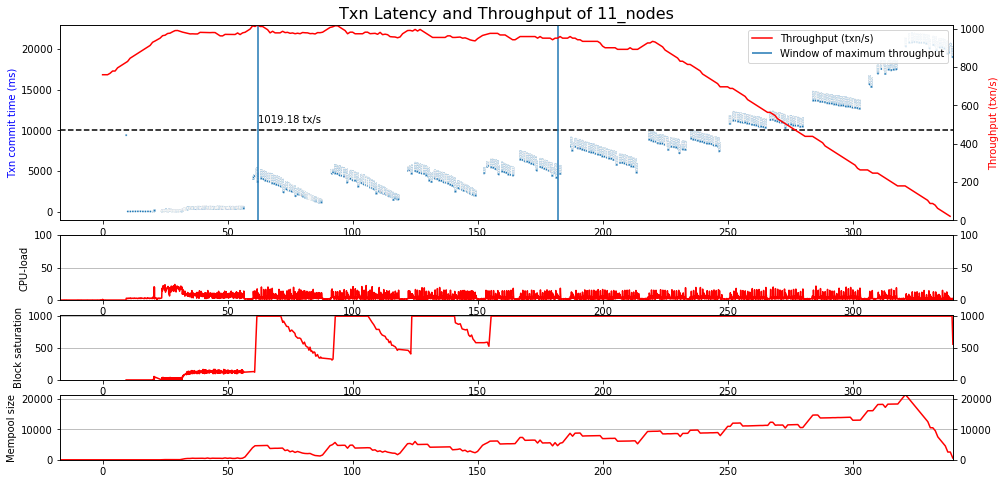

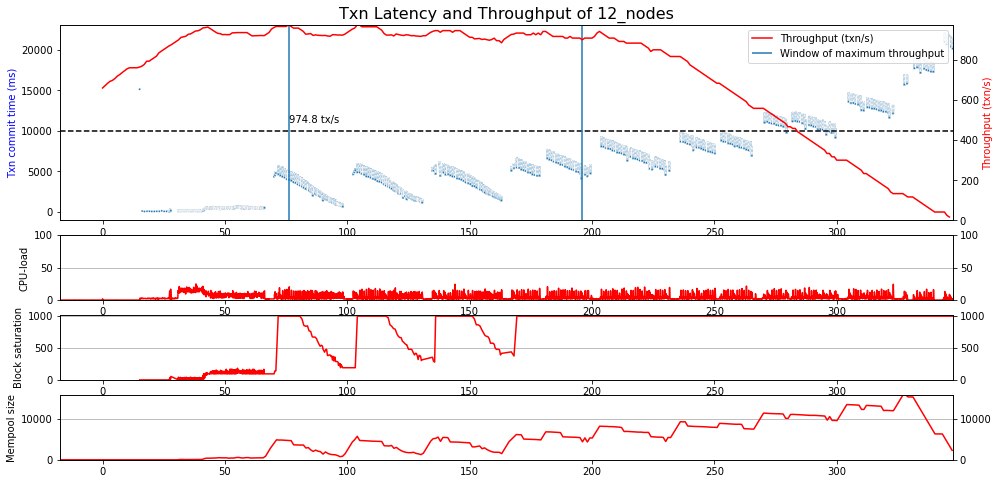

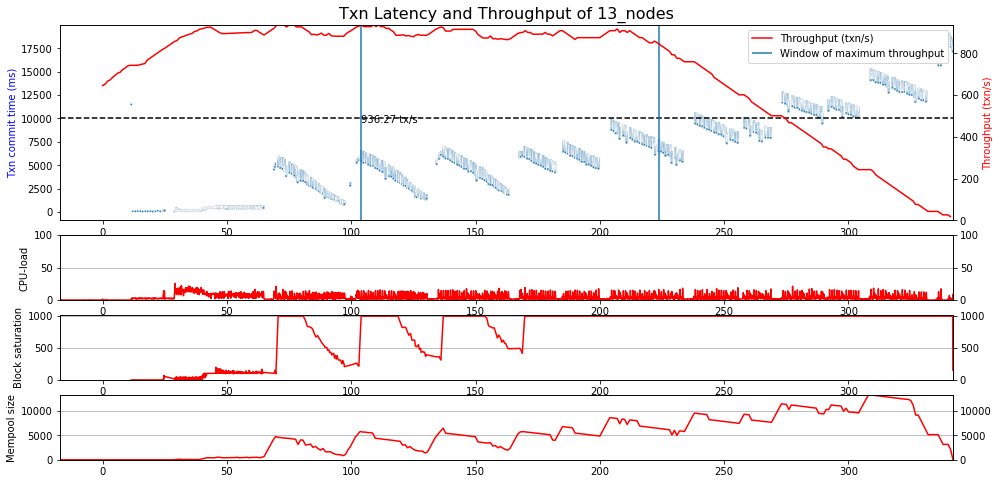

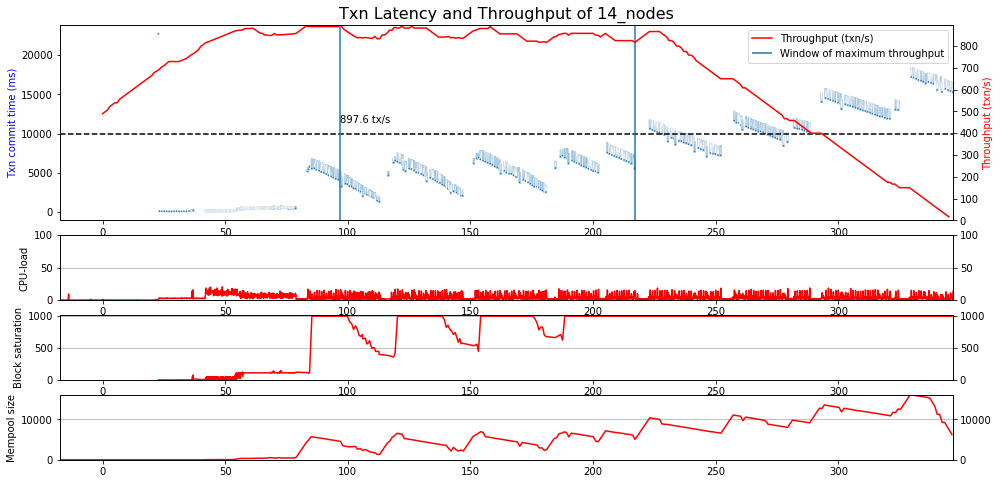

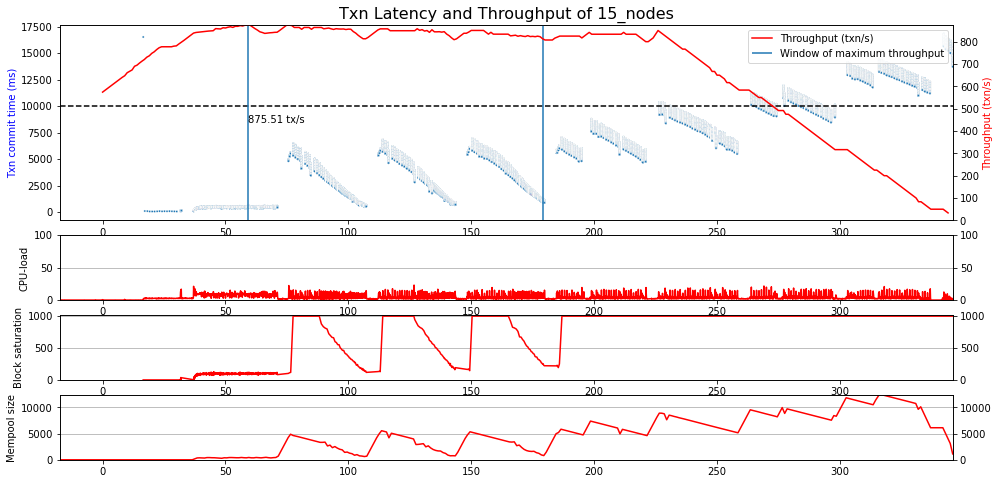

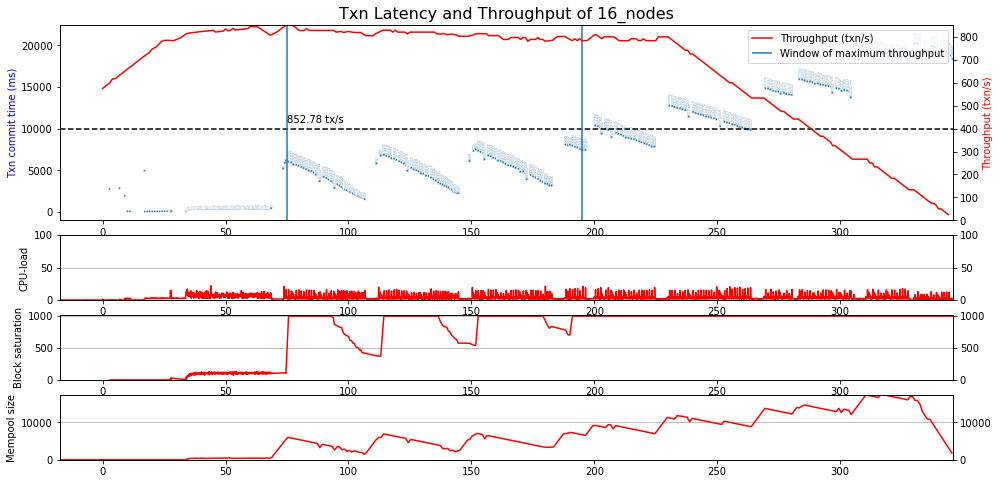

In [15]:
# Print the result graphs for experiment1_constant
#directory_exp1_constant = '/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment_test/'
#directory_exp1_constant = "/home/jeanpierre/libra2/libra2/experiments_logs/Experiment_compare_swarm_and_simulator/Experiment3/attempt2/"
directory_exp1_constant = "/home/jeanpierre/libra2/libra2/experiments_logs/hpc_logs/attempt10-8machines/"
#directory_exp1_constant = "/home/jeanpierre/libra2/libra2/experiments_logs/hpc_logs/compare2_to_10_machines_hpc/2machines/"

time_window = 120 #120

nr_nodes = []
nr_nodes_part1 = []
nr_nodes_part2 = []

for x_nodes in os.listdir(directory_exp1_constant):
    nr_nodes_part1.append(int(x_nodes.split('_')[0]))
    nr_nodes_part2.append(str(x_nodes.split('_')[1]))

nr_nodes_part1.sort()
for node_nr in range(len(nr_nodes_part1)):
    nr_nodes.append(str(nr_nodes_part1[node_nr]) + "_" + nr_nodes_part2[node_nr])

#nr_nodes = nr_nodes[:1]
    
max_throughput_experiment1_constant = []
max_mempool_size = []
for x_nodes in nr_nodes:
    for experiment_folder in os.listdir(directory_exp1_constant + x_nodes):
        directory_tmp = directory_exp1_constant + x_nodes + "/" + experiment_folder + "/"
        max_mempool_size.append(max(get_mempool_size_dataframe(directory_tmp)['size']))
        blockstore_dataframe, block_saturation = get_blockstore_dataframe_and_block_saturation(directory_tmp)
        max_throughput_tmp = plot_throughput_commit_times(blockstore_dataframe, directory_tmp, block_saturation, time_window, "Txn Latency and Throughput of " + x_nodes)
        max_throughput_experiment1_constant.append(x_nodes + "=" + str(int(max_throughput_tmp)))
        break

print("Performance: (txns/s)")
for line in max_throughput_experiment1_constant:    
    print(line)
    
print("Max mempool size:")
for index, line in enumerate(max_mempool_size):    
    print(str(nr_nodes[index]) + "=" + str(line))
    
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    block_saturation['timestamp_diff'] = block_saturation.diff(axis=0)['timestamp']
#    block_saturation = block_saturation[block_saturation['saturation'] == 1000]
#    print(block_saturation.describe())
#    print()
#    print(block_saturation)

In [12]:
def get_max_throughput(result, time_window):  
    #Find the maximum throughput
    max_throughput = 0
    for x in range(int(max(result['txn_rel_commit_time']))):
        rows = result.loc[(result['txn_rel_commit_time'] >= x) & (result['txn_rel_commit_time'] < x+time_window)]
        if len(rows) > max_throughput:
            max_throughput = len(rows)
            
    return max_throughput / time_window

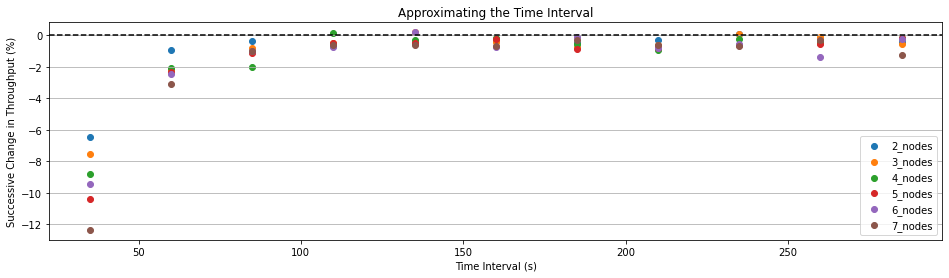

In [28]:
#Finding the stability interval duration
directory_exp1_constant = "/home/jeanpierre/libra2/libra2/experiments_logs/hpc_logs/attempt5/"

nr_nodes = []
nr_nodes_part1 = []
nr_nodes_part2 = []

for x_nodes in os.listdir(directory_exp1_constant):
    nr_nodes_part1.append(int(x_nodes.split('_')[0]))
    nr_nodes_part2.append(str(x_nodes.split('_')[1]))

nr_nodes_part1.sort()
for node_nr in range(len(nr_nodes_part1)):
    nr_nodes.append(str(nr_nodes_part1[node_nr]) + "_" + nr_nodes_part2[node_nr])
    
nr_nodes = nr_nodes[:6]

#time_window_list = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
time_window_list = np.arange(10, 300, 25)
max_throughput_df = pd.DataFrame()
max_throughput_df['time_window(s)'] = time_window_list
for x_nodes in nr_nodes:
    for experiment_folder in os.listdir(directory_exp1_constant + x_nodes):
        directory_tmp = directory_exp1_constant + x_nodes + "/" + experiment_folder + "/"
        blockstore_df = get_blockstore_dataframe(directory_tmp)
        max_throughput_tmp = []
        
        for time_window in time_window_list:
            max_throughput_tmp.append(get_max_throughput(blockstore_df, time_window))
            
        max_throughput_df[x_nodes] = max_throughput_tmp
        break

max_throughput_df = np.around(max_throughput_df, 1)
max_throughput_df_pct_change = max_throughput_df.pct_change() * 100
#print(max_throughput_df)
#print(max_throughput_df_pct_change)

fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.set_title("Approximating the Time Interval")
ax.set_xlabel('Time Interval (s)')
ax.set_ylabel('Successive Change in Throughput (%)')
for node in nr_nodes:
    ax.scatter(max_throughput_df['time_window(s)'], max_throughput_df_pct_change[node], label=node);
ax.axhline(y=0, c='black', ls='--')
ax.grid(axis='y')
ax.legend();

[1170. 1150. 1112. 1108. 1050. 1058. 1100. 1042. 1017. 1033.]
[1016.  995.  992.  936.  960.  950.  942.  925.  925.  917.]
[794. 816. 827. 823. 822. 800. 817. 783. 775. 767.]
[727. 724. 728. 741. 741. 725. 700. 667. 658. 650.]
[663. 678. 675. 658. 617. 592. 575. 575. 567. 542.]
[567. 583. 604. 600. 550. 525. 500. 500. 492. 490.]
[475. 504. 517. 508. 475. 467. 458. 433. 450. 442.]
[364. 451. 443. 450. 433. 417. 417. 400. 400. 400.]
[394. 455. 466. 459. 450. 425. 413. 408. 400. 404.]


Text(78.0, 0.5, '#Nodes')

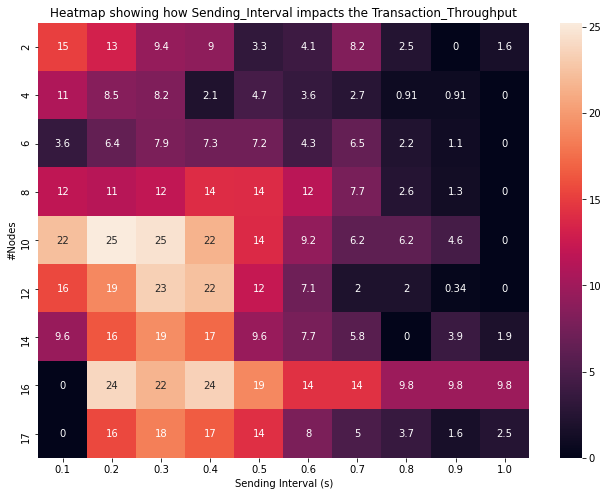

In [40]:
#Finding the optimal sending_interval_duration
directory_exp1_constant = "/home/jeanpierre/libra2/libra2/experiments_logs/Experiment_vary_sending_interval/"
time_window = 120

nr_nodes = []
nr_nodes_part1 = []
nr_nodes_part2 = []

interval_duration = []
interval_duration_part1 = []
interval_duration_part2 = []

for x_nodes in os.listdir(directory_exp1_constant):
    nr_nodes_part1.append(int(x_nodes.split('_')[0]))
    nr_nodes_part2.append(str(x_nodes.split('_')[1]))

nr_nodes_part1.sort()
for node_nr in range(len(nr_nodes_part1)):
    nr_nodes.append(str(nr_nodes_part1[node_nr]) + "_" + nr_nodes_part2[node_nr])

#PART2
    
for x_interval in os.listdir(directory_exp1_constant + nr_nodes[0]):
    interval_duration_part1.append(float(x_interval.split('_')[0]))
    interval_duration_part2.append(str(x_interval.split('_')[1]))
    
interval_duration_part1.sort()
for interval_nr in range(len(interval_duration_part1)):
    interval_duration.append(str(interval_duration_part1[interval_nr]) + "_" + interval_duration_part2[interval_nr])

throughput_results_2d_array = []

for x_nodes in nr_nodes:
    max_throughput_row = []
    for x_interval in interval_duration:
        for experiment_folder in os.listdir(directory_exp1_constant + x_nodes + "/" + x_interval):
            directory_tmp = directory_exp1_constant + x_nodes + "/" + x_interval + "/" + experiment_folder + "/"
            blockstore_df = get_blockstore_dataframe(directory_tmp)
            max_throughput_row.append(get_max_throughput(blockstore_df, time_window))
    
    print(np.round(max_throughput_row, 0))
    min_value = min(max_throughput_row)
    for value in range(len(max_throughput_row)):
        max_throughput_row[value] = round(((max_throughput_row[value]-min_value)/min_value*100), 2)
    
    throughput_results_2d_array.append(max_throughput_row)
    
fig, ax = plt.subplots(1, 1, figsize=(11,8))
sns.heatmap(throughput_results_2d_array, ax=ax, xticklabels=interval_duration_part1, yticklabels=nr_nodes_part1, annot=True);
ax.set_title("Heatmap showing how Sending_Interval impacts the Transaction_Throughput")
ax.set_xlabel("Sending Interval (s)")
ax.set_ylabel("#Nodes")

In [10]:
# Calculate the maximum throughput and return the results
def get_max_throughput_array(directory, time_window):
    nr_nodes = []
    nr_nodes_part1 = []
    nr_nodes_part2 = []

    for x_nodes in os.listdir(directory):
        nr_nodes_part1.append(int(x_nodes.split('_')[0]))
        nr_nodes_part2.append(str(x_nodes.split('_')[1]))

    nr_nodes_part1.sort()
    for node_nr in range(len(nr_nodes_part1)):
        nr_nodes.append(str(nr_nodes_part1[node_nr]) + "_" + nr_nodes_part2[node_nr])

    max_throughput = []
    local_values = []
    for x_nodes in nr_nodes:
        for experiment in os.listdir(directory + x_nodes):
            blockstore_df = get_blockstore_dataframe(directory + x_nodes + "/" + experiment + "/")
            local_values.append(get_max_throughput(blockstore_df, time_window))

        max_throughput.append(local_values)
        local_values = []
        
    return nr_nodes_part1, max_throughput

In [15]:
def plot_experiment1():
    nr_nodes_part1, max_throughput = get_max_throughput_array(directory_exp1, time_window)

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(x=nr_nodes_part1, y=max_throughput, color='antiquewhite')
    ax.set(xlabel="Number of Peers", ylabel = "Max Throughput (txns/s)")
    ax.set_title("Maximum throughput with a varying number of peers")
    for i in range(len(nr_nodes_part1)):
        ax.text(i, max_throughput[i], int(round(max_throughput[i], 0)), color='black', ha="center")
    plt.show()
    return max_throughput

In [12]:
def plot_experiment2():
    nr_nodes_part1, max_throughput = get_max_throughput_array(directory_exp2, time_window)

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(x=nr_nodes_part1, y=max_throughput, color='antiquewhite')
    ax.set(xlabel="Ping (ms)", ylabel = "Max Throughput (txns/s)")
    ax.set_title("Maximum throughput with a varying ping")
    for i in range(len(nr_nodes_part1)):
        ax.text(i, max_throughput[i], int(round(max_throughput[i], 0)), color='black', ha="center")
    plt.show()
    return max_throughput

In [13]:
def plot_experiment3():
    nr_nodes_part1, max_throughput = get_max_throughput_array(directory_exp3, time_window)

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(x=nr_nodes_part1, y=max_throughput, color='antiquewhite')
    ax.set(xlabel="Bandwidth (Mbit/s)", ylabel = "Max Throughput (txns/s)")
    ax.set_title("Maximum throughput with a varying bandwidth")
    for i in range(len(nr_nodes_part1)):
        ax.text(i, max_throughput[i], int(round(max_throughput[i], 0)), color='black', ha="center")
    plt.show()
    return max_throughput

In [14]:
def plot_experiment4():
    nr_nodes_part1, max_throughput = get_max_throughput_array(directory_exp4, time_window)

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(x=nr_nodes_part1, y=max_throughput, color='antiquewhite')
    ax.set(xlabel="Blocksize (txns)", ylabel = "Max Throughput (txns/s)")
    ax.set_title("Maximum throughput with a varying blocksize")
    for i in range(len(nr_nodes_part1)):
        ax.text(i, max_throughput[i], int(round(max_throughput[i], 0)), color='black', ha="center")
    plt.show()
    return max_throughput

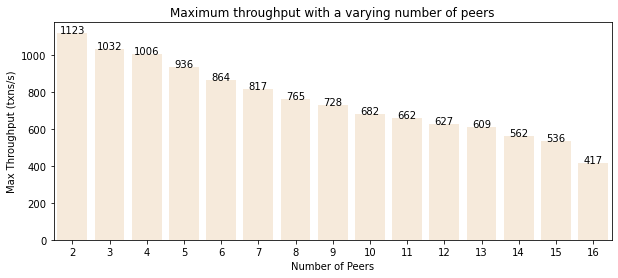

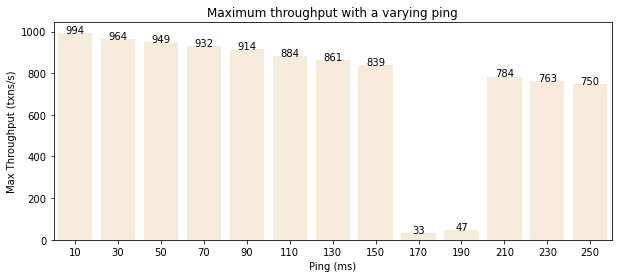

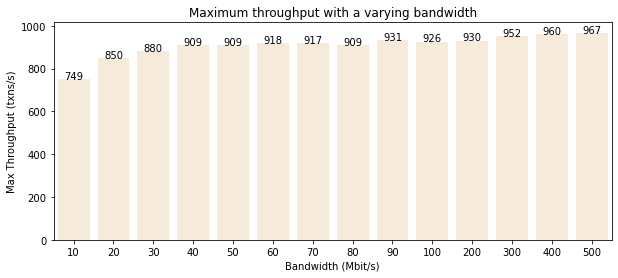

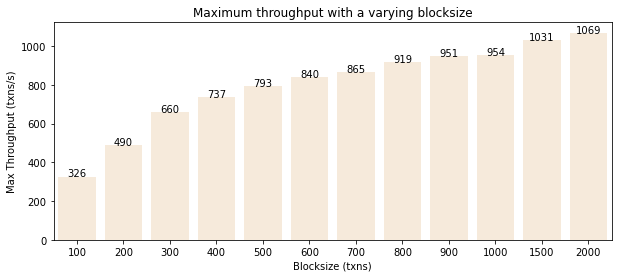

In [17]:
# Plot the results of experiment 1,2 and 3 in a barplot
directory_exp1 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment1_constant/attempt4/'
directory_exp2 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment2_constant/attempt4/'
directory_exp3 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment3_constant/attempt4/'
directory_exp4 = '/home/jeanpierre/libra2/libra2/experiments_logs/Experiment4_constant/attempt4/'

time_window = 120
max_throughput_exp1_libra = plot_experiment1()
max_throughput_exp2_libra = plot_experiment2()
max_throughput_exp3_libra = plot_experiment3()
max_throughput_exp4_libra = plot_experiment4()

In [18]:
for result in max_throughput_experiment1:
    print(result)

NameError: name 'max_throughput_experiment1' is not defined

In [27]:
for result in max_throughput_experiment2:
    print(result)

10_delay=900
30_delay=866
50_delay=850
70_delay=850
90_delay=825
110_delay=792
130_delay=777
150_delay=766
200_delay=737
250_delay=707
300_delay=658
400_delay=606
500_delay=566


In [28]:
for result in max_throughput_experiment3:
    print(result)

5_bandwidth=219
10_bandwidth=483
15_bandwidth=608
20_bandwidth=664
30_bandwidth=724
40_bandwidth=772
50_bandwidth=791
75_bandwidth=793
100_bandwidth=805
200_bandwidth=836
300_bandwidth=843
400_bandwidth=837
500_bandwidth=836


In [29]:
for result in max_throughput_experiment4:
    print(result)

100_blocksize=257
200_blocksize=411
300_blocksize=540
400_blocksize=650
500_blocksize=733
750_blocksize=793
1000_blocksize=866
1500_blocksize=914
2000_blocksize=927
5000_blocksize=1069
10000_blocksize=1001
50000_blocksize=950
100000_blocksize=1066


In [11]:
def libra_sim_comparison_bar_plot(bars1, bars2, x_label, x_ticklabels, plot_title):
    # set width of bar
    barWidth = 0.333333

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    ax.set_title(plot_title)
    
    # Calculate the mean and standard_error of the data
    mean_swarm = []
    std_error_swarm = []
    for experiment in bars1:
        mean_swarm.append(np.mean(experiment))
        std_error_swarm.append(np.std(experiment, ddof=1) / np.sqrt(len(experiment)))
        
    mean_simulator = []
    std_error_simulator = []
    for experiment in bars2:
        mean_simulator.append(np.mean(experiment))
        std_error_simulator.append(np.std(experiment, ddof=1) / np.sqrt(len(experiment)))
        
    # Make the plot
    ax.bar(r1, mean_swarm, yerr=std_error_swarm, color='#7f6d5f', width=barWidth, edgecolor='white', label='Libra Swarm')
    ax.bar(r2, mean_simulator, yerr=std_error_simulator, color='#557f2d', width=barWidth, edgecolor='white', label='Simulator')
    
    # Add xticks on the middle of the group bars
    ax.set_xlabel(x_label, fontweight='bold')
    ax.set_xticks([r + barWidth for r in range(len(bars1))])
    ax.set_xticklabels(x_ticklabels)
    ax.set_ylabel('Throughput (txns/s)', fontweight='bold')
    
    # Add percentage difference
    for i in range(len(mean_swarm)):
        max_throughput_label = max(mean_swarm[i], mean_simulator[i])
        ax.text(i + 0.15, max_throughput_label + max_throughput_label*0.03, str(round((mean_simulator[i] - mean_swarm[i])/mean_swarm[i]*100)) + "%", color='black', ha="center")

    # Create legend
    maximum_throughput = max(max(mean_swarm), max(mean_simulator)) + 0.1 * max(max(mean_swarm), max(mean_simulator))
    
    ax01 = ax.twinx()
    ax.set_ylim(0, maximum_throughput)
    ax01.set_ylim(0, maximum_throughput)
    ax.grid(axis='y')
    ax.legend()

In [12]:
def simulator_bar_plot(X_data, Y_data, X_label, plot_title):

    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    ax.set_title(plot_title)

    # Make the plot
    ax.plot(X_data, Y_data, color='#7f6d5f', label='Simulator')
    ax.set_xlabel(X_label, fontweight='bold')
    ax.set_ylabel('Throughput (txns/s)', fontweight='bold')

    ax.grid(axis='y')
    ax.legend()
    return ax

In [13]:
def get_sorted_label_names(directory):
    filenames = []
    for filename in os.listdir(directory):
        filenames.append(int(filename.split('_')[0]))

    filenames.sort()
    return filenames

In [14]:
def get_max_throughput_for_libra_sim(base_dir, label_name):

    max_throughput_array = []

    for experiment in get_sorted_label_names(base_dir):
        
        local_throughput_array = []
        data_dir = os.listdir(base_dir + str(experiment) + label_name)[0]
        for run_nr in os.listdir(base_dir + str(experiment) + label_name + data_dir):
            with open(base_dir + str(experiment) + label_name + data_dir + '/' + run_nr + '/' + 'output_run_info_data.txt') as fp:
                line = fp.readline()
                while line:
                    line = fp.readline()
                    if 'transaction_throughput_avg' in line:
                        throughput_avg = line.split('=')[1]
                        local_throughput_array.append(int(float(throughput_avg.rstrip("\n"))))
                        
        max_throughput_array.append(local_throughput_array)
        local_throughput_array = []
                    
    return max_throughput_array

In [27]:
#Comparison plots for Docker Swarm
#Max throughput arrays for Libra Swarm
time_window = 120
directory_exp1 = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment1/attempt1/'
directory_exp2 = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment2/attempt1/'
directory_exp3 = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment3/attempt1/'
directory_exp4 = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment4/attempt1/'
_, max_throughput_exp1_libra = get_max_throughput_array(directory_exp1, time_window)
_, max_throughput_exp2_libra = get_max_throughput_array(directory_exp2, time_window)
_, max_throughput_exp3_libra = get_max_throughput_array(directory_exp3, time_window)
_, max_throughput_exp4_libra = get_max_throughput_array(directory_exp4, time_window)

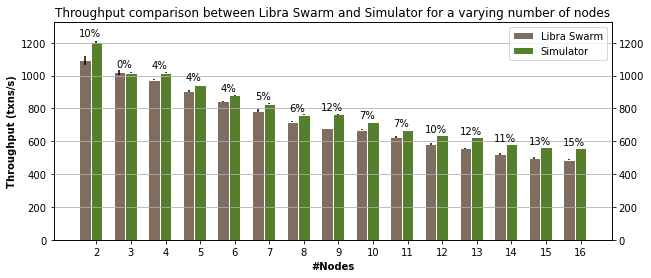

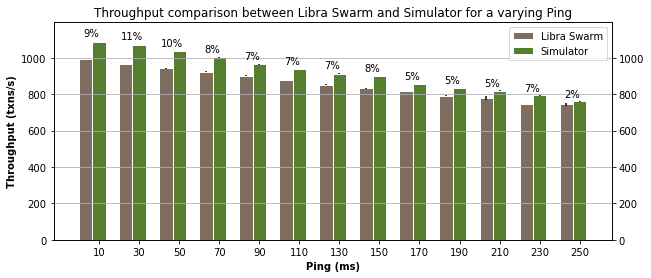

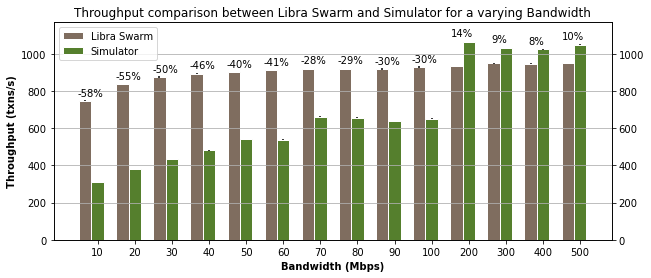

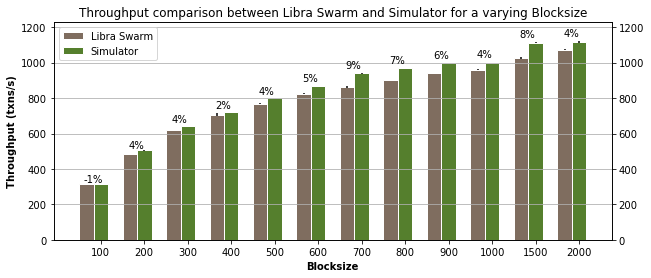

In [33]:
#Directories for the Simulator results
#base_dir_exp1 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment1-compare/attempt1/'
base_dir_exp1 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment1-compare/attempt1-noTimeout-fixed_dist/'
base_dir_exp2 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment2-compare/attempt1-noTimeout-fixed_dist/'
base_dir_exp3 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment3-compare/attempt1-noTimeout-fixed_dist/'
base_dir_exp4 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment4-compare/attempt1-noTimeout-fixed_dist/'
#base_dir_exp5 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment5/'

# Get the throughputs for the Libra-Simulator
#max_throughput_exp1_sim = get_max_throughput_for_libra_sim(base_dir_exp1, '_nodes/')
max_throughput_exp1_sim = get_max_throughput_for_libra_sim(base_dir_exp1, '_nodes/')
max_throughput_exp2_sim = get_max_throughput_for_libra_sim(base_dir_exp2, '_delay/')
max_throughput_exp3_sim = get_max_throughput_for_libra_sim(base_dir_exp3, '_bandwidth/')
max_throughput_exp4_sim = get_max_throughput_for_libra_sim(base_dir_exp4, '_blocksize/')
#max_throughput_exp5_sim = get_max_throughput_for_libra_sim(base_dir_exp5, '_nodes/')

# Plot and compare with Libra results
#libra_sim_comparison_bar_plot(max_throughput_exp1_libra, max_throughput_exp1_sim, '#Nodes', get_sorted_label_names(base_dir_exp1), 'Throughput comparison between Libra and Libra-Sim for a varying number of nodes (timeout=1Sec)')
libra_sim_comparison_bar_plot(max_throughput_exp1_libra, max_throughput_exp1_sim, '#Nodes', get_sorted_label_names(base_dir_exp1), 'Throughput comparison between Libra Swarm and Simulator for a varying number of nodes')
libra_sim_comparison_bar_plot(max_throughput_exp2_libra, max_throughput_exp2_sim, 'Ping (ms)', get_sorted_label_names(base_dir_exp2), 'Throughput comparison between Libra Swarm and Simulator for a varying Ping')
libra_sim_comparison_bar_plot(max_throughput_exp3_libra, max_throughput_exp3_sim, 'Bandwidth (Mbps)', get_sorted_label_names(base_dir_exp3), 'Throughput comparison between Libra Swarm and Simulator for a varying Bandwidth')
libra_sim_comparison_bar_plot(max_throughput_exp4_libra, max_throughput_exp4_sim, 'Blocksize', get_sorted_label_names(base_dir_exp4), 'Throughput comparison between Libra Swarm and Simulator for a varying Blocksize')
#simulator_bar_plot(get_sorted_label_names(base_dir_exp5), max_throughput_exp5_sim, '#Nodes', 'Throughput of Libra-Sim for a varying number of nodes')

In [18]:
#Comparison plots for HPC
#Max throughput arrays for Libra Swarm
time_window = 120 #120
directory_exp1 = '/home/jeanpierre/Desktop/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/hpc_logs/attempt10-8machines/'
#directory_exp2 = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment2/attempt1/'
#directory_exp3 = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment3/attempt1/'
#directory_exp4 = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment4/attempt1/'
_, max_throughput_exp1_libra = get_max_throughput_array(directory_exp1, time_window)
#_, max_throughput_exp2_libra = get_max_throughput_array(directory_exp2, time_window)
#_, max_throughput_exp3_libra = get_max_throughput_array(directory_exp3, time_window)
#_, max_throughput_exp4_libra = get_max_throughput_array(directory_exp4, time_window)

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jeanpierre/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


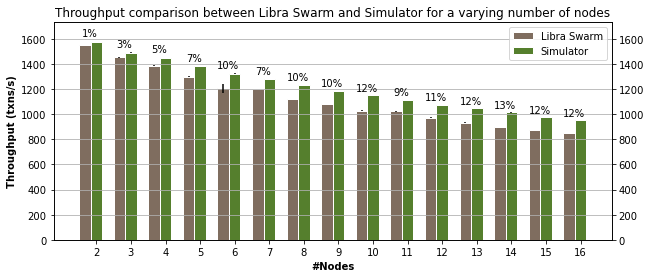

In [19]:
#Directories for the Simulator results
#base_dir_exp1 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment1-compare/attempt1/'
#base_dir_exp1 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment1-compare/attempt11-noTimeout-hpc-loggamma/'
base_dir_exp1 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment1-compare/attempt13-noTimeout-hpc-loggamma-8machines/'
#base_dir_exp2 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment2-compare/attempt1-noTimeout-fixed_dist/'
#base_dir_exp3 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment3-compare/attempt1-noTimeout-fixed_dist/'
#base_dir_exp4 = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment4-compare/attempt1-noTimeout-fixed_dist/'

# Get the throughputs for the Libra-Simulator
#max_throughput_exp1_sim = get_max_throughput_for_libra_sim(base_dir_exp1, '_nodes/')
max_throughput_exp1_sim = get_max_throughput_for_libra_sim(base_dir_exp1, '_nodes/')
#max_throughput_exp2_sim = get_max_throughput_for_libra_sim(base_dir_exp2, '_delay/')
#max_throughput_exp3_sim = get_max_throughput_for_libra_sim(base_dir_exp3, '_bandwidth/')
#max_throughput_exp4_sim = get_max_throughput_for_libra_sim(base_dir_exp4, '_blocksize/')

# Plot and compare with Libra results
libra_sim_comparison_bar_plot(max_throughput_exp1_libra, max_throughput_exp1_sim, '#Nodes', get_sorted_label_names(base_dir_exp1), 'Throughput comparison between Libra Swarm and Simulator for a varying number of nodes')
#libra_sim_comparison_bar_plot(max_throughput_exp2_libra, max_throughput_exp2_sim, 'Ping (ms)', get_sorted_label_names(base_dir_exp2), 'Throughput comparison between Libra Swarm and Simulator for a varying Ping')
#libra_sim_comparison_bar_plot(max_throughput_exp3_libra, max_throughput_exp3_sim, 'Bandwidth (Mbps)', get_sorted_label_names(base_dir_exp3), 'Throughput comparison between Libra Swarm and Simulator for a varying Bandwidth')
#libra_sim_comparison_bar_plot(max_throughput_exp4_libra, max_throughput_exp4_sim, 'Blocksize', get_sorted_label_names(base_dir_exp4), 'Throughput comparison between Libra Swarm and Simulator for a varying Blocksize')

[[1557.3083333333334, 1547.4166666666667, 1555.9083333333333, 1553.2, 1544.9333333333334], [1446.2, 1448.3, 1457.9583333333333, 1452.9333333333334, 1462.3833333333334], [1390.9333333333334, 1388.2666666666667, 1387.4, 1385.7083333333333, 1388.0], [1300.6333333333334, 1285.8333333333333, 1300.6, 1302.7333333333333, 1301.6666666666667], [1243.1666666666667, 1244.1666666666667, 1064.6583333333333, 1245.0, 1244.3333333333333], [1201.8, 1200.4, 1197.0583333333334, 1201.3333333333333, 1201.1], [1123.4916666666666, 1127.4666666666667, 1118.7, 1121.9333333333334, 1123.6], [1077.5, 1084.7333333333333, 1081.4666666666667, 1083.3333333333333, 1074.0333333333333], [1025.6666666666667, 1033.6333333333334, 1032.8333333333333, 1031.5583333333334, 1018.4916666666667], [1021.5333333333333, 1019.1833333333333, 1032.8, 1026.1333333333334, 1016.5333333333333], [974.7333333333333, 981.1333333333333, 974.8, 967.575, 970.1333333333333], [930.2666666666667, 936.2666666666667, 933.4666666666667], [897.6], [875

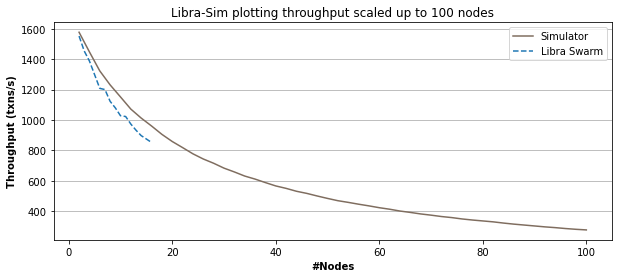

In [84]:
print(max_throughput_exp1_libra)
avg_throughputs = []
for throughputs in max_throughput_exp1_libra:
    avg_throughputs.append(np.mean(throughputs))

base_dir = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment1-compare/attempt13-noTimeout-hpc-loggamma-8machines-100nodes/'
max_throughput = get_max_throughput_for_libra_sim(base_dir, '_nodes/')
ax = simulator_bar_plot(get_sorted_label_names(base_dir), max_throughput, '#Nodes', 'Libra-Sim plotting throughput scaled up to 100 nodes')
ax.plot(range(2, len(avg_throughputs)+2), avg_throughputs, linestyle='dashed', label='Libra Swarm')
ax.legend()

In [69]:
print(len(max_throughput))
for throughput in max_throughput:
    sys.stdout.write(str(int(throughput[0]*.95)) + "," + "0,")

50
1498,0,1375,0,1256,0,1169,0,1094,0,1018,0,962,0,912,0,860,0,816,0,778,0,739,0,706,0,680,0,649,0,626,0,600,0,581,0,559,0,538,0,523,0,505,0,492,0,475,0,460,0,446,0,436,0,424,0,414,0,402,0,393,0,381,0,373,0,363,0,356,0,347,0,341,0,332,0,325,0,320,0,314,0,306,0,300,0,294,0,288,0,283,0,278,0,272,0,267,0,264,0,

No handles with labels found to put in legend.


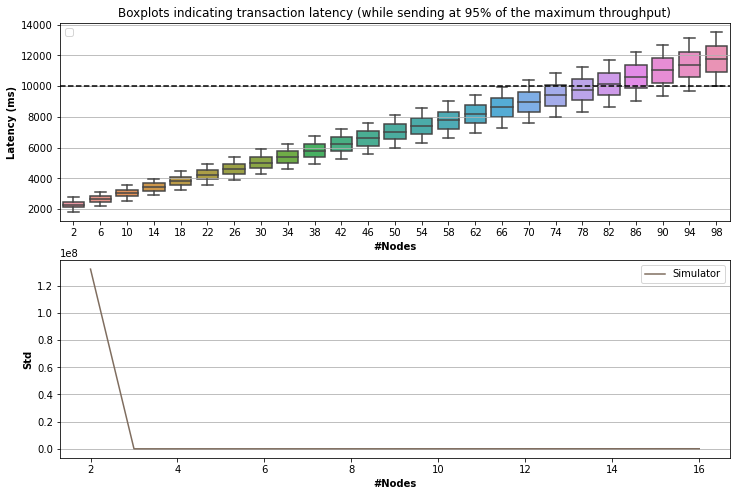

In [83]:
base_dir_sim = '/mnt/DownloadsWindowsShared/LibraSimulator-Results/LibraSim-Experiment-latency/attempt1-noTimeout-hpc-loggamma-attempt10-8machines/'

dictionary = {"latency":[], "nodes":[]}
for experiment in get_sorted_label_names(base_dir_sim):
        latencies_array_local = []
        data_dir = os.listdir(base_dir_sim + str(experiment) + '_nodes')[0]
        for run_nr in os.listdir(base_dir_sim + str(experiment) + '_nodes/' + data_dir):
            with open(base_dir_sim + str(experiment) + '_nodes/' + data_dir + '/' + run_nr + '/' + 'output_transaction_latency_time.txt') as fp:
                line = fp.readline()
                while line:
                    dictionary["latency"].append(int(line.split(',')[1]))
                    dictionary["nodes"].append(int(experiment))
                    line = fp.readline()
                    
latencies_dataframe = pd.DataFrame(dictionary)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8))
ax0.set_title("Boxplots indicating transaction latency (while sending at 95% of the maximum throughput)")

# Make the plot
#ax0.plot(range(2, len(mean_array_sim)+2), mean_array_sim, color='#7f6d5f', label='Simulator')
sns.color_palette("YlOrBr", as_cmap=True)
sns.boxplot(x="nodes", y="latency", data=latencies_dataframe, ax=ax0)
ax0.axhline(y=10000, c='black', ls='--')
ax0.set_xlabel('#Nodes', fontweight='bold')
ax0.set_ylabel('Latency (ms)', fontweight='bold')

ax0.grid(axis='y')
ax0.legend()

ax1.plot(range(2, len(std_array_sim)+2), std_array_sim, color='#7f6d5f', label='Simulator')
ax1.set_xlabel('#Nodes', fontweight='bold')
ax1.set_ylabel('Std', fontweight='bold')

ax1.grid(axis='y')
ax1.legend();